#============================================================================================================================================
# **Física Teórica 3 (Mecánica Estadística): Trabajo Práctico**
#============================================================================================================================================

### *Bibliotecas*

Importamos las bibliotecas de Python que vamos a usar: numpy, que permite definir y operar con matrices, genera números aleatorios, incluye todo tipo de funciones matemáticas, etc.; matplotlib.pyplot, que permite hacer gráficos; y numba, que es un compilador que hace que las funciones corran mucho más rápido. También importamos la función curve_fit del paquete scipy.optimize, que nos servirá para hacer ajustes.

In [ ]:
import numpy             as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from numba          import njit
from scipy.optimize import minimize

## **Introducción**

El objetivo de la práctica es calcular varios observables (magnetización, energía, susceptibilidad, calor específico) de una red de Ising bidimensional en función de la temperatura. También calcularemos la función de correlación y estudiaremos la dependencia de la longitud de correlación con la temperatura. Usaremos unidades en las que $J=k=1$.

Más precisamente, el objetivo es ver cómo, si $T\approx 2.27$ y si la red es lo suficientemente grande, los observables tienen un comportamiento *abrupto*. En una red finita, no esperamos encontrar una transición de fase, pero los experimentos con redes finitas deben apuntar en esa dirección.

Es posible calcular la función de partición exacta para redes de hasta unos cientos de espines por lado. Para una red de $512 \times 512$ espines se necesitan unos 8 GB de memoria para guardar la función de partición. Desde un punto de vista práctico, las cosas rápidamente se vuelven inmanejables. Sin embargo, los experimentos numéricos pueden llegar mucho más allá de una red de $512 \times 512$. En lugar de calcular la función de partición exacta, lo que hacemos es generar estados aleatorios de la red distribuidos según el ensamble canónico, y tomar promedios sobre varios de esos estados. Para lograr eso, partimos de un estado inicial cualquiera y le aplicamos el **algoritmo de Metropolis**, que consta de los siguientes pasos:

1.   Elegimos un sitio de la red al azar.
2.   Calculamos la diferencia de energía $\Delta E$ que resultaría de dar vuelta a ese espín.
3. Si $\Delta E\le 0$, le damos vuelta al espín; si $\Delta E>0$, le damos vuelta al espín con probabilidad $e^{-\beta\Delta E}$.

Al estado resultante le volvemos a aplicar el algoritmo, y así sucesivamente. Después de ser iterado muchas veces, el algoritmo empieza a generar estados distribuidos según el ensamble canónico. Tomando promedios sobre varios de esos estados, podremos calcular los observables de interés.

La práctica tiene en cuenta la finitud de la vida humana, así que el objetivo no es hacer experimentos con redes desmesuradamente grandes.

Un consejo, para que administren su tiempo. Pueden usar la biblioteca **tqdm** para mostrar barras de progreso. Como muestra la celda de abajo.

In [6]:
import numpy as np
from tqdm import tqdm

n = 0
for i in tqdm(range(1, 1_000_000)):
  n += 1/(i*i)

print(np.sqrt(6*n))
print(np.pi)

100%|██████████| 999999/999999 [00:00<00:00, 1580057.81it/s]

3.141591698659554
3.141592653589793


#———————————————————————————————————————————————————————————————————————————————————————————————
## **Funciones**
#———————————————————————————————————————————————————————————————————————————————————————————————

Aquí van a tener que definir dos funciones. La primera, **`h(S)`**, calcula la energía por partícula de la red en el estado **`S`** (nótese que **`S`** es una matriz de unos y menos unos). Asumimos que no hay campo magnético y usamos condiciones de contorno periódicas, de manera que el primer espín de una fila/columna es vecino del último. Si la red es $L\times L$, la energía total es entonces

$$H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1}),$$

y la energía por partícula es esto dividido por $L^2$. La segunda función que tienen que definir,  **`metropolis(S,prob)`**, aplica el algoritmo de Metropolis al estado **`S`** y devuelve tres cosas: un nuevo estado **`S`**, el incremento de magnetización **`dm`** y el incremento de energía por partícula **`de`**. Deben notar que los únicos valores positivos que puede tomar el incremento de energía $\Delta E$ resultante de dar vuelta a un espín son $\Delta E=4$ y $\Delta E=8$; el argumento **`prob`** es un vector de dos componentes, **`prob[0]`** y **`prob[1]`**, que son las probabilidades con las que daremos vuelta al espín si el incremento de energía es $4$ y $8$ respectivamente. Algunos consejos:


*   Para implementar las condiciones de contorno periódicas, conviene recordar que las listas de Python empiezan con el elemento $0$. Si la red tiene lado $L$, el último elemento es el $L - 1$. Alternativamente,  el elemento $-1$ es el último, el $-2$ el penúltimo, etc. También les va a ser útil la función **`%`**, que calcula el resto de la división entre dos enteros (es decir, **`m%n`** es el resto de la división entre **`m`** y **`n`**). Esto es útil para implementar las condiciones de contorno periódicas sin tener que tratar de manera distinta a los espines que están en los bordes de la red.
*   ¡Sean económicos! Para calcular $\Delta E$ no deben calcular la energía total de los dos estados (el estado original y el estado con el espín seleccionado dado vuelta) y restar, sino darse cuenta de que esta cantidad sólo involucra al estado del espín seleccionado y el de sus cuatro primeros vecinos.
*   Para dar vuelta a un espín con probabilidad $p$, lo que hacemos es generar un número aleatorio entre $0$ y $1$ y dar vuelta el espín si ese número es menor que $p$.

Una vez hayan definido estas funciones, primero de todo asegúrense de que andan bien probándolas con una matriz $3\times 3$, por ejemplo, tomando **`S=np.ones((3,3))`**. Ahí pueden calcular a mano la energía por partícula y chequear que **`h(S)`** da el resultado correcto. También pueden asegurarse de que, partiendo de esta misma matriz, la funcion **`metropolis(S,prob)`** da vuelta a algún espín más fácilmente a temperaturas altas que a temperaturas bajas, y que los incrementos de magnetización y energía por partícula que calcula son los correctos. Una vez hayan hecho eso, redefinan la función **`metropolis(S,prob)`** de manera que aplique el algoritmo de Metropolis no una sola vez sino tantas como sitios tiene la red. Es decir, su función definitiva debería aplicar el algoritmo al estado original, y después volvérselo a aplicar al estado resultante, y así tantas veces como sitios tiene la red. De vuelta, comprueben que esta función anda bien con una matriz sencilla. El proceso de repetir el algoritmo elemental $L \times L$ veces es lo que se llama **un paso** de Montecarlo.

In [13]:
@njit                                         # Para que numba compile la función
def h(S):                                     # Calcula la energía de la red en el estado S
  H = 0
  for i in range(S.shape[0]):
    for j in range(S.shape[1]):
      H += -S[i, j] * (S[i-1, j] + S[i, j-1])
  return H/(len(S)**2)

@njit
def metropolis(S, prob):                               # Aplica el algoritmo de Metropolis al estado S
  dm = 0                                               # Incremento de la magnetización
  de = 0                                               # Incremento de la energía
  deltaE = 0                                           # Delta E
  S_est = S                                            # Estado actual
  for it in range(0, len(S)**2):                       # Para cada sitio
    i_rand, j_rand = np.random.randint(0, len(S), 2)
    num = np.random.uniform(0, 1)
    deltaE = 2*S[i_rand][j_rand] * (S[(i_rand+1)%len(S)][j_rand] + S[i_rand][(j_rand+1)%len(S)] + S[i_rand-1][j_rand] + S[i_rand][j_rand-1])
    if (deltaE > 0) and ((deltaE == 4 and num > prob[0]) or (deltaE == 8 and num > prob[1])):
      pass
    else:
      S[i_rand][j_rand] = -S[i_rand][j_rand]
      dm += 2*S[i_rand][j_rand]
      de += deltaE
  return S, dm/(len(S)**2), de/(len(S)**2)

In [14]:
S = np.random.choice([1, -1], size=(3, 3)) # Probamos una matriz de 3x3:
#S = -np.ones((3,3))
#print(de)

In [15]:
print(S[0][0])
print(S)
print(h(S))

-1
[[-1 -1  1]
 [ 1 -1 -1]
 [ 1  1  1]]
0.2222222222222222


### Energía de la red

La energía de la red en un estado S se calcula con la función $h(S)$. En esta función se recorren todos los elementos de matriz $i, j$ sumándole al valor de $H$ la energía de interacción entre el spin $(i,j)$ con el spin $(i,j-1)$ y el spin $(i-1,j)$.

### Metrópolis

Para generar el algoritmo de Metrópolis, se crea la función $\text{Metropolis}(S, \text{prob})$. Aquí, se calcula la variación en la energía que se produce como consecuencia de elegir un spin al azar y estudiar el posible cambio en su proyección (de $1$ a $-1$ y viceversa). Este cálculo se realiza estudiando la energía de un estado final $E_{\text{final}}$, y la energía de un estado inicial $E_{\text{inicial}}$; se tiene en cuenta únicamente la interacción del spin $(i,j)$ con sus vecinos:

$$ E_{\text{final}} = - (-S_{i,j}) ⋅ (S_{i+1,j} + S_{i,j+1} + S_{i-1,j} + S_{i,j-1})$$

$$ E_{\text{inicial}} = - (S_{i,j}) ⋅ (S_{i+1,j} + S_{i,j+1} + S_{i-1,j} + S_{i,j-1})$$

Con lo cual, resulta

$$ \boxed{\Delta E = 2 S_{i,j} ⋅ (S_{i+1,j} + S_{i,j+1} + S_{i-1,j} + S_{i,j-1})}$$

En el código, la variable $\text{num}$ toma un valor aleatorio entre $0$ y $1$. Si el cambio en energía es $4$ y el valor de $\text{num}$ es mayor que $\text{prob}[0]$, el estado no cambia (la función devuelve el mismo estado). Ocurre lo mismo si el cambio es $8$ y el valor de $\text{num}$ es mayor que $\text{prob[1]}$. En cambio, tanto si el cambio en energía es menor o igual a $0$ como si el valor de $\text{num}$ resulta menor que $\text{prob}[0]$ o $\text{prob}[1]$, se cambia el spin de la posición $(i_\text{rand},j_\text{rand})$
Finalmente, el cambio en la magnetización se calcula teniendo en cuenta que si el spin es $+1$ y pasa a $-1$, el cambio en la magnetización es $-\frac{2}{L^2}$.
Si es $-1$ y pasa a $+1$, el cambio en la magnetización es $\frac{2}{L^2}$.
Con lo cual, se tiene que:
$$ \boxed{dm = 2 \frac{S_{i,j}}{L^2}} $$
siendo $S_{i,j}$ el spin luego del cambio. Notar que $dm$ se haya dividido por $L^2$, lo cual normalizaa la magnetización entre valores $-1$ y $1$. El algoritmo se repite $L^2$ veces.

Notamos que la aparición del método $(\%)$ establece la condición de borde: si en alguna iteración se escoge un valor aleatorio de $i$ o de $j$ que dirige a una posición del borde de la matriz $S$, el índice $i+1$ o $j+1$ arroja un error. En cambio, el valor de $(j+1)\%/\text{len}(S)$ arroja el valor $0$, con lo cual el código vuelve al principio de la grilla, explicitando así la condición de contorno periódica.

#———————————————————————————————————————————————————————————————————————————————————————————————
## **Termalización**
#———————————————————————————————————————————————————————————————————————————————————————————————

Partiendo de un cierto estado inicial, estudiamos cuántos pasos son necesarios para que el sistema llegue al equilibrio, es decir, para que los distintos estados empiecen a estar distribuidos según el ensamble canónico. Para eso, graficamos la magnetización y la energía por partícula en función del paso; el equilibrio se alcanza cuando estas cantidades empiezan a fluctuar alrededor de un valor fijo, en lugar de ser netamente crecientes o decrecientes.
El número de pasos necesarios para alcanzar el equilibrio dependerá de la temperatura, así que hay que hacer el análisis para varias temperaturas. También puede depender del lado de la red, así que cuando cambien el valor de este parámetro van a tener que rehacer este análisis. Fíjense que, cerca de la temperatura crítica, la magnetización oscila entre $1$ y $-1$.

100%|██████████| 19999/19999 [00:03<00:00, 5223.05it/s]


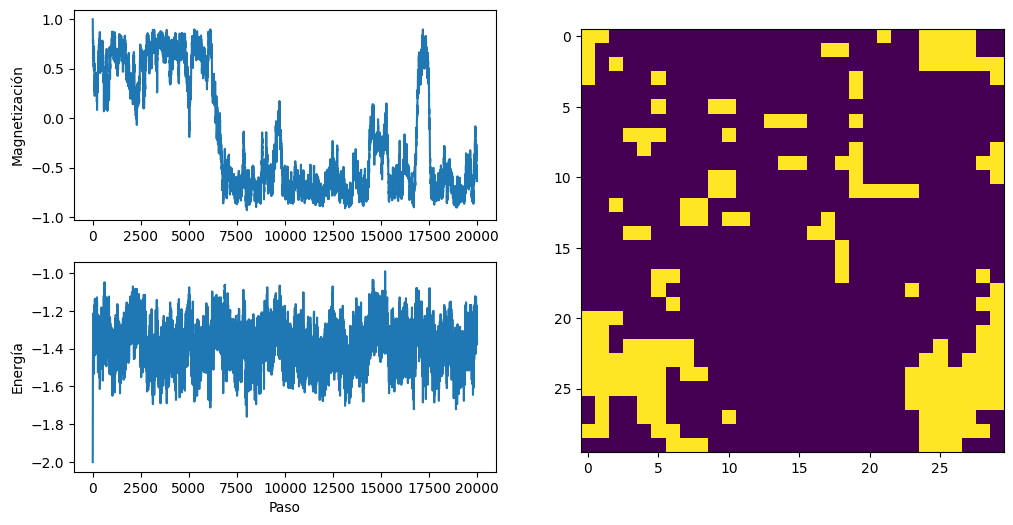

In [ ]:
L           = 30                    # Lado de la red
beta        = 1/2.3                 # k=1, T = 2.3
nequilibrio = 20000                 # Número de pasos tentativo para llegar al equilibrio (20000 el original)
m           = np.zeros(nequilibrio) # magnetización en función del paso
e           = np.zeros(nequilibrio) # energia por particula en funcion del paso

# Estado inicial:
S=np.ones((L,L),dtype=int)             # Opcion 1: todos los spines apuntan para arriba
#S=2*np.random.randint(2,size=(L,L))-1 # Opcion 2: matriz aleatoria de 1's y -1's
m[0]=np.mean(S)
e[0]=h(S)

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])
for n in tqdm(range(1,nequilibrio)):
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm
  e[n]=e[n-1]+de

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(m)
plt.ylabel('Magnetización')
plt.subplot(2,2,3)
plt.plot(e)
plt.ylabel('Energía')
plt.xlabel('Paso')
plt.subplot(1,2,2)
plt.imshow(S)               # plotea el estado final, dandole un color al 1 y otro al -1
plt.show()

#———————————————————————————————————————————————————————————————————————————————————————————————
## **Promedios**
#———————————————————————————————————————————————————————————————————————————————————————————————

Estudiamos cuántos pasos hacen falta para calcular buenos promedios. Para eso, graficamos el valor medio de la magnetización y la energía por partícula en función del número de pasos utilizados para calcularlo (empezando a contar después de haber llegado al equilibrio). Cuando el valor medio se haga constante, el número de pasos será suficiente. De vuelta, el número de pasos apropiado depende de la temperatura y del lado de la red. Van a ver que, cerca de la temperatura crítica, las fluctuaciones se hacen más grandes y por lo tanto es necesario promediar sobre un número más grande de pasos. Para librarnos de las fluctuaciones de la magnetización entre $1$ y $-1$ cerca de la temperatura crítica, que son inmanejables, lo que tomamos es **el valor medio de su módulo**.

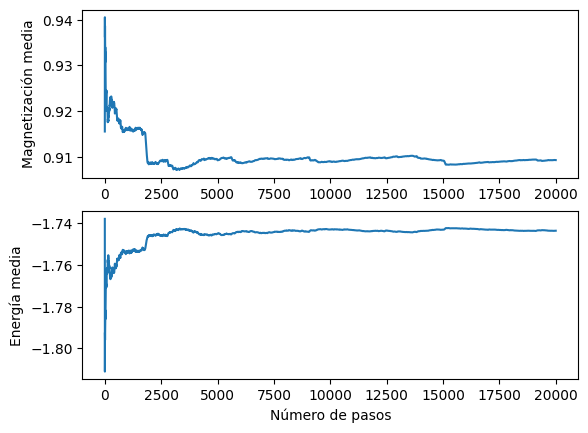

In [ ]:
L           = 30
beta        = 1/2
nequilibrio = 1000                # Este valor lo decidimos en base a lo anterior
npromedio   = 20000               # Numero de pasos tentativo para calcular promedios
m           = np.zeros(npromedio) # Magnetizacion y energia por particula en funcion del paso
e           = np.zeros(npromedio)

S=np.ones((L,L),dtype=int) # Estado inicial
prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

for n in range(nequilibrio):
  S,dm,de=metropolis(S,prob) # Termalizamos

m[0]=np.mean(S)
e[0]=h(S)

mmedia=[abs(m[0])]
emedia=[e[0]]      # Valores medios en funcion del numero de pasos para promediar

for n in range(1,npromedio):
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm
  e[n]=e[n-1]+de
  mmedia.append(np.mean(abs(m[0:n+1])))
  emedia.append(np.mean(e[0:n+1]))

plt.figure()
plt.subplot(2,1,1)
plt.plot(mmedia)
plt.ylabel('Magnetización media')
plt.subplot(2,1,2)
plt.plot(emedia)
plt.ylabel('Energía media')
plt.xlabel('Número de pasos')
plt.show()

**Explicación**
Podemos ver que al aumentar el número de pasos tanto la energía como la magnetización llegan a un equilibrio, a partir de aproximadamente 5000 puntos ambas magnitudes se estabilizan. En este caso calculamos para la red de lado L=30 y una temperatura de T=2 K.

#———————————————————————————————————————————————————————————————————————————————————————————————
## **Transición de fase**
#———————————————————————————————————————————————————————————————————————————————————————————————

Aquí hay que calcular la magnetización media, la energía media por partícula, la susceptibilidad y el calor específico para varias temperaturas, graficar el resultado y ver que a una temperatura cercana a la crítica se produce un comportamiento casi brusco. Algunos consejos:

*   Para calcular la susceptibilidad y el calor específico no hay que tomar ninguna derivada, hay que usar la relación entre estas cantidades y la varianza de la magnetización y la energía por partícula respectivamente.
*   No propongan un nuevo estado inicial para cada temperatura: aprovechen el último estado de la temperatura anterior, porque así van a necesitar menos pasos para termalizar. Si empiezan a temperaturas bajas, conviene tomar como estado inicial la matriz de unos, y si empiezan a temperaturas altas conviene tomar como estado inicial una matriz aleatoria de unos y menos unos.
*   Conviene dar más pasos para termalizar y/o tomar promedios cerca de la temperatura crítica que lejos de ella.

Aquí se muestran unos gráficos tìpicos. El de la susceptibilidad puede mejorarse.

Debido a que el calor específico y la susceptibilidad magnética pueden relacionarse con la energía y magnetización de la forma:

$$\left\{ {\begin{align} c_V &= \dfrac{N\beta}{T} \left[{\langle{E^2}\rangle - {\langle{E}\rangle}^2}\right] \\ \chi &= N \beta \left[{\langle{M^2}\rangle - {\langle{M}\rangle}^2}\right] \end{align}} \right.$$

In [ ]:
L    = 30                       # Lado de la red
N    = 20000                    # Número de pasos tentativo para llegar al equilibrio (20000 el original)
T    = np.linspace(1.5,3.5,100) # Hacemos una lista de valores de T bajos
beta = 1/T                      # Creamos un vector beta
S    = np.ones((L,L),dtype=int)

In [ ]:
energia = []         # Creo las listas vacías de energía y magnetización
magnetizaciones = []
suscep = []
cv = []

# Corremos metrópolis nuevamente:
for x in tqdm(beta):                         # Para los valores de beta, calculamos el valor medio de energía y magnetización.
  prob=np.array([np.exp(-4*x),np.exp(-8*x)])
  for n in range(N):
    S,dm,de=metropolis(S,prob)               # Termalizamos

  m=np.zeros(N)
  e=np.zeros(N)      # Magnetizacion y energia por particula en funcion del paso
  m[0]=np.mean(S)
  e[0]=h(S)
  mmedia=[abs(m[0])]
  emedia=[e[0]]      # Valores medios en funcion del numero de pasos para promediar

  for n in range(1,N):
    S,dm,de=metropolis(S,prob)
    m[n]=m[n-1]+dm
    e[n]=e[n-1]+de
    mmedia.append(np.mean(abs(m[0:n+1])))
    emedia.append(np.mean(e[0:n+1]))

  energia.append(emedia[-1])
  magnetizaciones.append(mmedia[-1])
  suscep.append((L**2)*x*(np.std(abs(m))**2)) # Utilizamos el valor absoluto porque si no daba mal.
  cv.append((L**2)*(x**2)*(np.std(e)**2))     # Utilizamos la desviación estandar de e

100%|██████████| 100/100 [12:23<00:00,  7.43s/it]


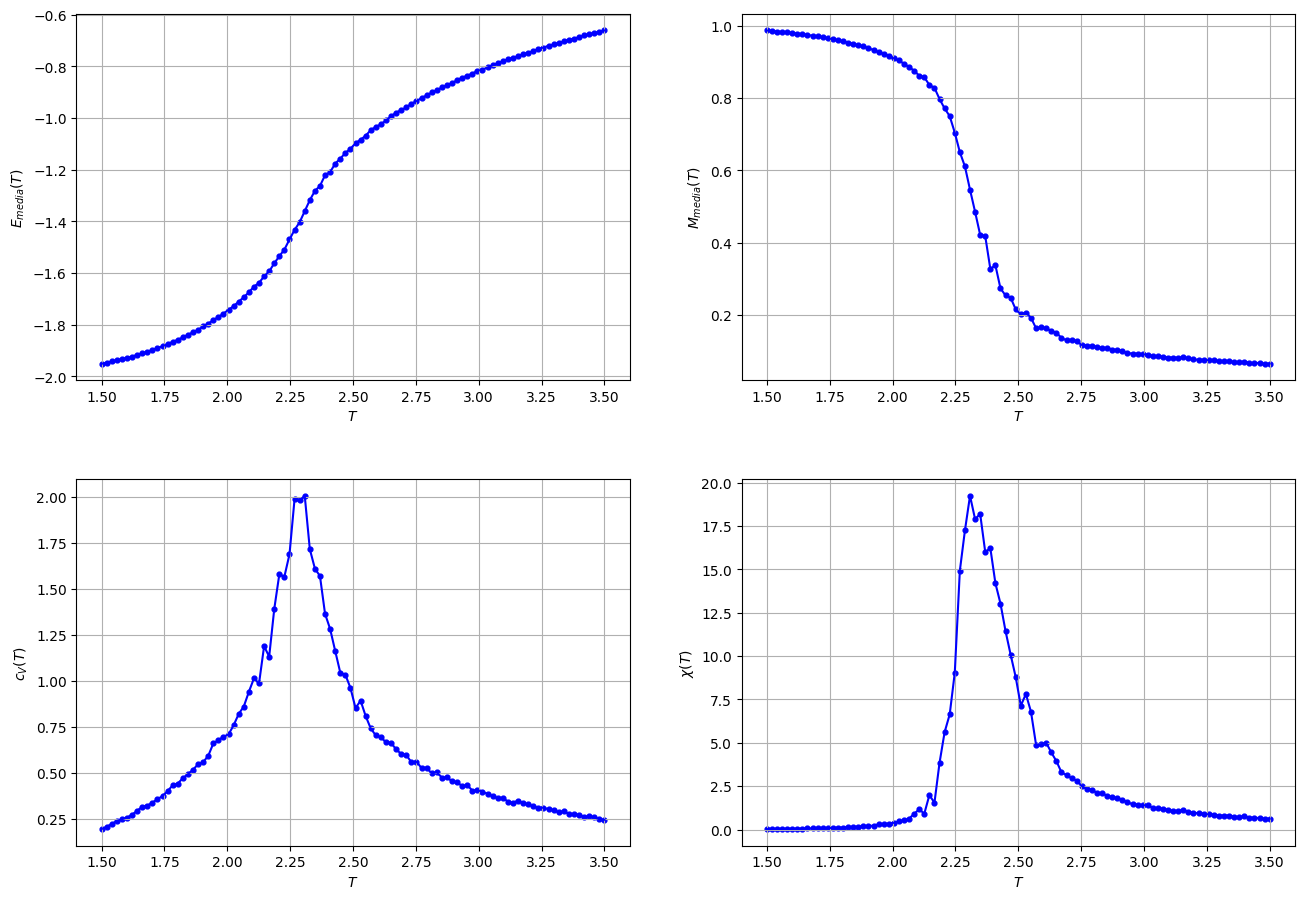

In [ ]:
fig, ax = plt.subplots(2, 2, figsize= (14,10))
plt.tight_layout(pad=5.0)

ax[0,0].plot(T,energia, linewidth=1.5, color='blue')
ax[0,0].scatter(T,energia, color='blue', s=12)
ax[0,0].set_xlabel('$T$', fontsize = 10)
ax[0,0].set_ylabel('$E_{media}(T)$', fontsize = 10)
ax[0,0].grid(True)

ax[0,1].plot(T,magnetizaciones, linewidth=1.5, color='blue')
ax[0,1].scatter(T,magnetizaciones, color='blue', s=12)
ax[0,1].set_xlabel('$T$', fontsize = 10)
ax[0,1].set_ylabel('$M_{media}(T)$', fontsize = 10)
ax[0,1].grid(True)

ax[1,0].plot(T,cv, linewidth=1.5, color='blue')
ax[1,0].scatter(T,cv, color='blue', s=12)
ax[1,0].set_xlabel('$T$', fontsize = 10)
ax[1,0].set_ylabel('$c_V(T)$', fontsize = 10)
ax[1,0].grid(True)

ax[1,1].plot(T,suscep, linewidth=1.5, color='blue')
ax[1,1].scatter(T,suscep, color='blue', s=12)
ax[1,1].set_xlabel('$T$', fontsize = 10)
ax[1,1].set_ylabel('$\chi(T)$', fontsize = 10)
ax[1,1].grid(True)

**Explicación:**
En esta ocasión, lo que hicimos fue utilizar la red de L=30 espines y un total de N=20000 puntos, creamos un vector de T utilizando linspace con 100 puntos, y definimos el beta como 1 sobre esos valores. Luego, creamos las listas de energía media, magnetización media, calor específico y susceptibilidad y corremos el algoritmo de metrópolis para calcular estas cuatro magnitudes para cada uno de los 100 valores de temperatura.
Luego, ploteamos y obtuvimos los gráficos de arriba.


### Comparación con los datos calculados analíticamente

Para estar seguros de que están haciendo las cosas bien, [aquí](https://drive.google.com/file/d/1sfsT2yqvdG0YHFHTcoAdrXIpef6EMv9R/view?usp=drive_link) pueden bajar el calor específico por partícula  como función de la temperatura, calculado exactamente, para la red de 32x32, y [aquí](https://drive.google.com/file/d/1zSnolG_9DMnR-k_ZillLK4VAz2N33Ztv/view?usp=drive_link) la energía media. Los archivos son dos tablas en formato .csv con resultados numéricos obtenidos a partir de la función de partición exacta. Hagan dos gráficos que muestren sus resultados experimentales comparados con las curvas teóricas. Acoten el rango de valores del eje horizontal al rango de valores experimentales. Como la red es pequeña, tiene que haber poquísimo ruido (miren la figura 16.1 de la última edición del libro de Pathria & Beale). [Aquí](https://drive.google.com/drive/folders/1qh0loWq7viENgYd0ssUEx_bLi-s-LlZC?usp=drive_link) pueden bajar los datos exactos para otras redes.
![pathria_16_1](http://materias.df.uba.ar/ft3a2024c1/files/2024/06/pathria_16_1.png)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Extraigo los datos de un txt, que contiene los valores de cv contra t (agregamos una fila que dice cv y T)
cv_teorico, T_cv_teorico = np.loadtxt('/content/drive/My Drive/Colab Notebooks/T3 | Física Teórica 3/Práctica Computacional/datoscv.txt', skiprows=1).T
e_teorico, T_e_teorico = np.loadtxt('/content/drive/My Drive/Colab Notebooks/T3 | Física Teórica 3/Práctica Computacional/datosu.txt', skiprows=1).T

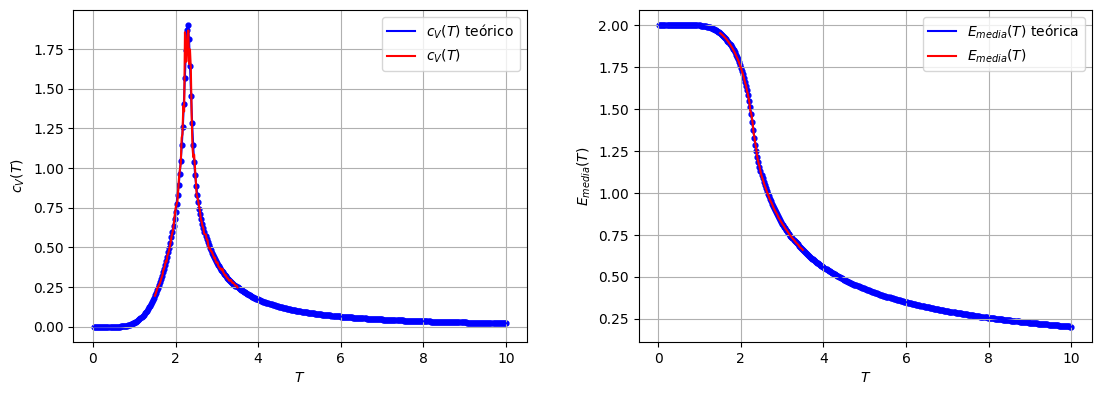

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (12,5))
plt.tight_layout(pad=5.0)

ax[0].plot(cv_teorico,T_cv_teorico, linewidth=1.5, color='blue', label='$c_V(T)$ teórico')
ax[0].scatter(cv_teorico,T_cv_teorico, color='blue', s=12)
ax[0].plot(T,cv, linewidth=1.5, color='red', label='$c_V(T)$')
ax[0].set_xlabel('$T$', fontsize = 10)
ax[0].set_ylabel('$c_V(T)$', fontsize = 10)
ax[0].grid(True)
ax[0].legend()

ax[1].plot(e_teorico,T_e_teorico, linewidth=1.5, color='blue', label='$E_{media}(T)$ teórica')
ax[1].scatter(e_teorico,T_e_teorico, color='blue', s=12)
ax[1].plot(T,-np.array(energia), linewidth=1.5, color='red', label='$E_{media}(T)$')
ax[1].set_xlabel('$T$', fontsize = 10)
ax[1].set_ylabel('$E_{media}(T)$', fontsize = 10)
ax[1].grid(True)
ax[1].legend()

**Explicación:**
En esta ocasión, ploteamos los datos de calor específico con respecto a temperatura calculados teóricamente para la red de L=32 que importamos del archivo.csv, y lo mismo hicimos para la energía media con respecto a la temperatura.
Podemos ver que los datos obtenidos por metrópolis para el calor específico y para la energía estan contenidos en la curva propuesta teóricamente.
En el caso de la energía, tuvimos que cambiarla de signo dado que suponemos que el modelo teórico asumía que la energía era positiva.

#———————————————————————————————————————————————————————————————————————————————————————————————
## **Correlaciones**
#———————————————————————————————————————————————————————————————————————————————————————————————

La **función de correlación** se define como $g(r)=\langle s_{ij}s_{ij+r}\rangle-\langle s_{ij}\rangle\langle s_{ij+r}\rangle$, y se sabe que tiene la forma $g(r)=ae^{-r/\xi}$. A $\xi$ se lo conoce como la **longitud de correlación**, y es una función de la temperatura que, en el límite termodinámico, diverge a la temperatura crítica. El objetivo de esta sección es ver eso.

Lo primero que hay que hacer es definir dos funciones. La primera, **`cor(S)`**, devuelve un vector $c$ de $L/2$ componentes, donde $L$ es el lado de la red, cuya componente $r$ es el promedio de $s_{ij}s_{ij+r}$ sobre toda la red, es decir,

$c(r)=\frac{1}{L^2}\sum_{i,j=1}^Ls_{ij}s_{ij+r}.$

La segunda función, **`metropolis2(S,prob)`**, implementa el algoritmo de Metropolis, igual que hacía la función **`metropolis(S,prob)`**, pero esta vez, en lugar de devolver el nuevo estado, el incremento de la magnetización y el incremento de energía, devuelve el nuevo estado, el incremento de la magnetización y el incremento del vector $c$. Para definir estas dos funciones deberán prestar mucha atención a las condiciones de contorno periódicas, y tener en cuenta que $c(0)=1$ independientemente del estado, así que el incremento de $c(0)$ siempre es $0$.

In [ ]:
from numpy.fft import fft, ifft
def cor(S):                                           # Realiza la convolución como multiplicación en el espacio de Fourier.
  L = S.shape[1]
  S_f = fft(S, axis=1)
  cor = np.sum(ifft(S_f*S_f.conj(), axis=1), axis=0)
  return np.real(cor[:L // 2]) / S.size

def metropolis2(S, prob):
  L = len(S)
  ci = cor(S)
  S, dm, _ = metropolis(S, prob)
  dc = cor(S) - ci
  # return S, dm / (L**2), dc / (L**2)
  return S, dm, dc / (L**2)

**Explicación:**

Para calcular la correlación, se debe hacer una convolución sobre uno de los ejes. La convolución en el espacio de Fourier es una multiplicación.
Por eso, usamos la librería fft para llevar a S al espacio de Fourier, convolucionarla con sí mísma multiplicando su representación en Fourier, invirtiendo la correlación, tomando su parte real.

Luego, para el algoritmo de metrópolis2 construímos sobre la base de metrópolis, calculando el diferencial en la correlación. De esa forma, conseguimos un algoritmo eficiente para ambas funciones.

Ahora usamos las funciones que acabamos de definir para calcular la función de correlación a tres temperaturas distintas. Ajustamos los datos obtenidos con una función de la forma $a e^{-r/\xi}$, y de ahí obtenemos la longitud de correlación a esas tres temperaturas.

Longitud de correlacion:


100%|██████████| 49999/49999 [00:05<00:00, 9331.05it/s]


T=1.5 => 0.017210902364672806


100%|██████████| 49999/49999 [00:05<00:00, 8932.35it/s]


T=2.3 => 2.2680987550423204


100%|██████████| 49999/49999 [00:06<00:00, 7588.68it/s]


T=3 => 0.7424705760461661


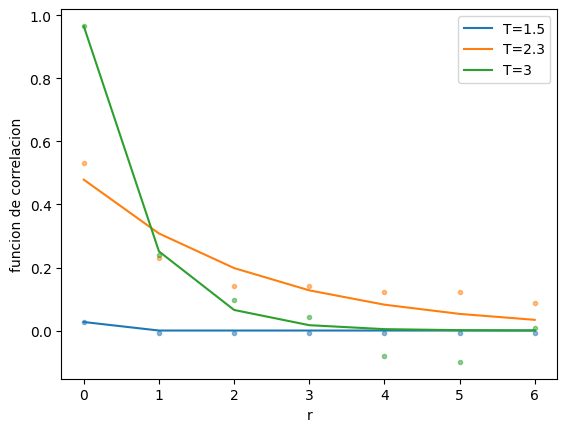

In [ ]:
L           = 15
nequilibrio = 50000
npromedio   = 50000
l           = int(L/2)                # Número de componentes del vector c
m           = np.zeros(npromedio)     # Magnetización en funcion del paso
c           = np.zeros((l,npromedio)) # Vector c en funcion del paso
erres       = np.arange(l)            # Dominio de la funcion de correlacion

def fitcor(r,a,xi):      # Función con la que vamos a ajustar
  return a*np.exp(-r/xi)

S=np.ones((L,L),dtype=int)

print('Longitud de correlacion:')

for i, T in enumerate([1.5,2.3,3]):
  beta=1/T
  prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])
  for n in range(nequilibrio):                              # Termalizamos con la funcion metropolis(S,prob), que es mas rapida
    S,dm,de=metropolis(S,prob)
  m[0]=np.mean(S)
  c[:,0]=cor(S)
  for n in tqdm(range(1,npromedio)):
    S,dm,dc=metropolis2(S,prob)
    m[n]=m[n-1]+dm
    c[:,n]=c[:,n-1]+dc
  mmedia=np.mean(abs(m))
  correlacion=np.mean(c,axis=1)-mmedia**2                   # Función de correlacion
  parametros,covarianza=curve_fit(fitcor,erres,correlacion) # Ajustamos
  print('T={} => {}'.format(T,parametros[1]))
  plt.plot(erres, correlacion, '.', alpha=0.5, color=f'C{i}')
  plt.plot(erres,fitcor(erres,parametros[0],parametros[1]),label='T={}'.format(T))
plt.xlabel('r')
plt.ylabel('funcion de correlacion')
plt.legend()
plt.show()

Por último, hay que barrer un rango de temperaturas que incluya la crítica y obtener un gráfico de la longitud de correlación en función de la temperatura.

In [ ]:
L           = 15
nequilibrio = 50000
npromedio   = 50000
l           = int(L/2)                 # Número de componentes del vector c
m           = np.zeros(npromedio)      # Magnetización en función del paso
c           = np.zeros((l,npromedio))  # Vector c en función del paso
erres       = np.arange(l)             # Dominio de la función de correlacion
S           = np.ones((L,L),dtype=int)
long_corr   = []
Temp        = np.linspace(1.5, 3.5, 100)

for T in tqdm(Temp):
  beta = 1/T
  prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])
  for n in range(nequilibrio):
    S,dm,de=metropolis(S,prob)                              # Termalizamos con la función metropolis(S,prob), que es más rápida
  m[0]=np.mean(S)
  c[:,0]=cor(S)
  for n in range(1,npromedio):
    S,dm,dc=metropolis2(S,prob)
    m[n]=m[n-1]+dm
    c[:,n]=c[:,n-1]+dc
  mmedia=np.mean(abs(m))
  correlacion=np.mean(c,axis=1)-mmedia**2                   # Función de correlación
  parametros,covarianza=curve_fit(fitcor,erres,correlacion) # Ajustamos
  long_corr.append(parametros[1])

  3%|▎         | 3/100 [00:25<13:13,  8.18s/it]<ipython-input-11-f2fb1706a403>:12: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-r/xi)
100%|██████████| 100/100 [12:46<00:00,  7.66s/it]


Bueno, previo a esta prueba habiamos pensado que lo que había que cambiar era el nequilibrio (leimos mal el mail). Pero con un neq muy grande y un nprom chico, para una red de L=100 el grafico se veía bastante razonable, adjuntamos foto en mail.



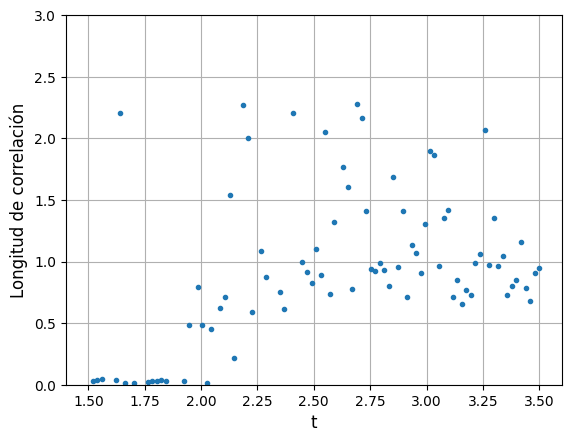

In [15]:
plt.figure()
plt.xlabel('t', fontsize=12)
plt.ylim(0, 3)
plt.ylabel('Longitud de correlación', fontsize=12)
plt.plot(Temp,long_corr, '.')
plt.grid()

**Explicación:**

Usando las funciones cor y metropolis2 en la celda de codigo que estaba escrita y pudimos ajustar, con la exponencial, los valores de correlación obtenidos en función de r.

En la segunda celda de código nos proponemos replicar el gráfico de longitud de correlación en función de T. Para esto utilizamos la mayor parte del codigo mencionado en el parrafo anterior, solo que en lugar de graficar el ajuste con los datos, lo que hicimos fue guardar, en una lista, el parametro del ajuste de la exponencial que correspondia con la longitud de correlación. Esto lo hicimos para 50 temperaturas diferentes y luego graficamos longitud de correlación en función de T.


#———————————————————————————————————————————————————————————————————————————————————————————————
## **Temperatura crítica**
#———————————————————————————————————————————————————————————————————————————————————————————————

La teoría de **finite-size scaling** (Fisher y Barber, Physical Review Letters **28**, 1972) muestra que, para una red de Ising bidimensional de lado $L$, el pico de la susceptibilidad ocurre a una temperatura $T_c(L)$ dada por

$$T_c(L)=T_c+\frac{a}{L},$$

donde $T_c$ es la temperatura crítica del sistema en el límite termodinámico y $a$ es una constante. Lo que deben hacer en esta sección es determinar $T_c(L)$ para $L=15,30,60,120$ con una precisión aproximada de $0.01$, graficar en función de $1/L$, ajustar los puntos a una recta y de ahí obtener una estimación para la temperatura crítica.

La figura de abajo muestra resultados para la susceptibilidad de una red de 30x30. Noten que para elegir el pico de la susceptibilidad no es una buena idea quedarse con el punto experimental más alto, porque hay bastante ruido. Ajusten una cuadrática cerca del máximo y busquen el máximo de la cuadrática. De ahí también van a poder obtener barras de error para hacer el ajuste lineal de $T_c$ y dar también un error.

![](http://materias.df.uba.ar/ft3a2024c1/files/2024/06/30x30.png)

Cuando entreguen el notebook completo, agreguen los 4 gráficos correspondientes con las parábolas ajustadas y los datos de los máximos y del error.

Estén preparados para tener que tomar muchísimos pasos para calcular promedios en la red de 120x120. En general, empiecen haciendo mediciones espaciadas y con pocos pasos para estimar la posición del máximo y luego refinen las mediciones, con más pasos y menos amplitud de temperaturas.

**Primer paso:** Defino las funciones para ajustar y de error

In [ ]:
def lineal(x,a,b): # Defino funciones lineal y cuadrática
  return a*x + b

def cuadratica(x,a,b,c):
  return a*(x - b)**2 + c

def maximo(a,b): # Defino una función para hallar el máximo de la cuadrática
  return b

def error_T(a,b,a_err,b_err): # Defino función de propagación de errores
  return np.sqrt( (b**2/(4*(a**4))) * (a_err**2) + (1/(4*(a**2))) * (b_err**2) )

### L = 15

Empezamos con la red de 15x15. Como en la sección de promedios vimos que se alcanza el equilibrio alrededor de N=7000, usaré N=10000 en todos.

In [ ]:
L    = 15                          # Lado de la red
N    = 10000                       # Número de pasos para llegar al equilibrio
S    = np.ones((L,L),dtype=int)
T    = np.linspace(2.35,2.55,1000) # Creo una lista de valores de T bajos y cercanos al equilibrio
beta = 1/T                         # Creo el vector beta
#print(beta)

In [ ]:
suscep_15 = [] # Creo una lista vacía para hallar los datos de susceptibilidad

for x in tqdm(beta):                         # Para los valores de beta, termalizamos, calculamos el valor medio de energía y magnetización.
  prob=np.array([np.exp(-4*x),np.exp(-8*x)])
  for n in range(N):
    S,dm,de=metropolis(S,prob)               # Termalizamos con metrópolis
  m=np.zeros(N)
  e=np.zeros(N)                              # Magnetizacion y energia por particula en funcion del paso
  m[0]=np.mean(S)
  e[0]=h(S)
  mmedia=[abs(m[0])]
  emedia=[e[0]]                              # Valores medios en funcion del numero de pasos para promediar
  for n in range(1,N):
    S,dm,de=metropolis(S,prob)
    m[n]=m[n-1]+dm
    e[n]=e[n-1]+de
    mmedia.append(np.mean(abs(m[0:n+1])))
    emedia.append(np.mean(e[0:n+1]))
  suscep_15.append(x*(np.std(abs(m))**2))

print(suscep_15)

100%|██████████| 1000/1000 [17:57<00:00,  1.08s/it]

[0.0212067199559548, 0.022569301899157106, 0.019412286724551864, 0.022580249966361824, 0.020379450790304524, 0.02227681190652791, 0.02335941655854166, 0.02296693527511579, 0.021062889659139432, 0.023479601783888703, 0.019934521362302126, 0.020384357930927174, 0.020012969411267557, 0.021293696501053054, 0.02362613645314902, 0.02165517161103415, 0.026052494664149578, 0.020654601682822557, 0.02455290326320495, 0.0254507457616886, 0.025114748830213078, 0.023760846055290975, 0.020198652755325227, 0.02110190592598575, 0.023144054135646942, 0.023510800427450965, 0.024432770625291467, 0.022496416251606505, 0.028345797044185404, 0.021419250244153903, 0.020176596753014826, 0.02126917869399662, 0.0245433814529751, 0.020886743510842114, 0.026072414261203537, 0.02567844108251048, 0.019275419609175375, 0.02160985004610634, 0.023734782350424508, 0.021525331822624068, 0.02571595050213853, 0.02481619780580712, 0.024486092546576917, 0.020556186022818744, 0.021085660018761547, 0.024160734703497465, 0.020

##### Vector suscep_15 (lo escribo en caso de que se borre sin querer la rutina corrida de arriba)

In [ ]:
suscep_15 = [0.0212067199559548, 0.022569301899157106, 0.019412286724551864, 0.022580249966361824, 0.020379450790304524, 0.02227681190652791, 0.02335941655854166, 0.02296693527511579, 0.021062889659139432, 0.023479601783888703, 0.019934521362302126, 0.020384357930927174, 0.020012969411267557, 0.021293696501053054, 0.02362613645314902, 0.02165517161103415, 0.026052494664149578, 0.020654601682822557, 0.02455290326320495, 0.0254507457616886, 0.025114748830213078, 0.023760846055290975, 0.020198652755325227, 0.02110190592598575, 0.023144054135646942, 0.023510800427450965, 0.024432770625291467, 0.022496416251606505, 0.028345797044185404, 0.021419250244153903, 0.020176596753014826, 0.02126917869399662, 0.0245433814529751, 0.020886743510842114, 0.026072414261203537, 0.02567844108251048, 0.019275419609175375, 0.02160985004610634, 0.023734782350424508, 0.021525331822624068, 0.02571595050213853, 0.02481619780580712, 0.024486092546576917, 0.020556186022818744, 0.021085660018761547, 0.024160734703497465, 0.020611168807830777, 0.02188582009998374, 0.021160948237593222, 0.02282149198510147, 0.02165280089271265, 0.024687621556311594, 0.023855040754747918, 0.022419495024852017, 0.02277692750721986, 0.02340169481896735, 0.022878029245749373, 0.026959818406448868, 0.021240340046207937, 0.022372367394936973, 0.023902065844680315, 0.022793468365039014, 0.02143163724542561, 0.02450302484036754, 0.02206922442573814, 0.025308099072175322, 0.020813114778486252, 0.026956535667824633, 0.02373263637500933, 0.02400179035266858, 0.023542590231636327, 0.02408255307367811, 0.026240543610345262, 0.023865002330742967, 0.02198792670321067, 0.022827186686614855, 0.022479918558915433, 0.020069396057314635, 0.025256495337504414, 0.024340592096469098, 0.02402447176697508, 0.021757556249379587, 0.02368696730731974, 0.022239878481823287, 0.025809003974149338, 0.024360025751006386, 0.022023118396971176, 0.02141535468989832, 0.024162386662438726, 0.02362272187658839, 0.020539724019694096, 0.023972573904647083, 0.020373025872505928, 0.02616705252089283, 0.02218090899077358, 0.025168485535615265, 0.02379515055893527, 0.024793771390849092, 0.02223929452081081, 0.022075955337617546, 0.021542826111701763, 0.024720717963524142, 0.022597700798934695, 0.024756605663084647, 0.02695658532975857, 0.022604241389803197, 0.025141857927479302, 0.025827009791079686, 0.022595076401712492, 0.023424320878939264, 0.023578387802084995, 0.023037853398365848, 0.023796918947494507, 0.02422626232385165, 0.023824835039890812, 0.02347528636054414, 0.02580237241075451, 0.025135794273472685, 0.025342396741634146, 0.025346544301817035, 0.0219366217769446, 0.024446398514784105, 0.02397281386459367, 0.023247397110215777, 0.022997837773593852, 0.0231706593778984, 0.02293466027850729, 0.022389653101871985, 0.022207963695336484, 0.02132263763426907, 0.022197635331717258, 0.024033788651982784, 0.024030525706014046, 0.023196706171817308, 0.02408785897289789, 0.0274979090218028, 0.022272535881475732, 0.021446266633921775, 0.023191654997117773, 0.02227431395775283, 0.024500763720465, 0.023746958164755066, 0.01916258819623719, 0.025064415691543097, 0.020422296864489476, 0.023046356030408083, 0.022136216908198097, 0.02375529061470752, 0.023091310288850874, 0.025212783033249943, 0.027335782600372612, 0.023698565758676588, 0.025586310994028423, 0.02417683939086416, 0.02446873762055119, 0.023986048197239086, 0.022988040503981278, 0.02486062387397091, 0.025402463347980467, 0.025498082590877724, 0.022982434359320576, 0.02320850449497125, 0.023447522868627692, 0.025535859293543125, 0.02128889302857756, 0.026107901413340625, 0.025281654997025966, 0.025196815707382827, 0.02114338307740332, 0.0230559714108071, 0.024553819458055282, 0.025318764490459084, 0.023278255390064877, 0.02425461614346769, 0.02282982668548647, 0.02632613488828979, 0.02415518816543214, 0.026240871780729196, 0.025514282559679916, 0.022803541882068432, 0.02595910283846932, 0.021131120433490306, 0.024431548974533233, 0.024943887943813508, 0.022751782396931285, 0.026434156130043955, 0.023917143277007186, 0.023747981844238052, 0.025102269759680215, 0.022537423421832643, 0.026928711831045303, 0.025087405104148735, 0.023019142687537988, 0.025536534662342993, 0.026411102882597924, 0.02247035803347673, 0.02156339140663324, 0.019974093185261072, 0.024526959062267154, 0.024320560677681492, 0.024314867909339115, 0.020845523835725, 0.02295263160047067, 0.02437632964790117, 0.024060364108271046, 0.024482796633773885, 0.025226775026327555, 0.022514770938406467, 0.02296316045100455, 0.023915309823432176, 0.024836740967484467, 0.021753587373114322, 0.022822929544407212, 0.026646470031837628, 0.021642105450409156, 0.02377045720577081, 0.02179257571158476, 0.02344924271384262, 0.025005010911418962, 0.02464499126076203, 0.02375599249611491, 0.023885546523799338, 0.02143832562899718, 0.024386887106521468, 0.023225476561612293, 0.02606635561289116, 0.023429402896021044, 0.025264452619359105, 0.02441742341942935, 0.02409513915627626, 0.023314806822357485, 0.023633934337183467, 0.02443000655313073, 0.022317241098113123, 0.02413909191553914, 0.025749076081431517, 0.02416991645127387, 0.023066742300056085, 0.024017615310595555, 0.02240712191351656, 0.023734597746637998, 0.02349290308271825, 0.025149640897782, 0.024677044227089245, 0.026056632102825418, 0.024633264551102596, 0.025559899284895878, 0.022664737974987602, 0.021283302145192442, 0.025242857445831768, 0.023566458665425442, 0.024629976477901452, 0.021476928497132782, 0.02539484442448618, 0.023454419854751742, 0.024392063131733758, 0.024795831062828705, 0.024995108343657136, 0.02223796415137951, 0.023534312026399398, 0.02351170241791816, 0.025118647342232205, 0.022197029139164017, 0.02396227379209774, 0.023953003849173767, 0.023010764278647833, 0.024961710090405195, 0.02505331800270713, 0.026052804931769147, 0.025000635277963996, 0.02293469288603645, 0.024058745916689186, 0.02370441453758695, 0.025708872861896367, 0.02364492092699816, 0.024229414410947878, 0.024457608049712073, 0.02461195154005564, 0.02409118810191641, 0.023403125382622472, 0.02378663877603473, 0.02644662100058936, 0.024678863667090656, 0.020555900242875465, 0.023864379757315507, 0.022849838943997114, 0.025179850320814448, 0.021427716050383985, 0.023767084830927914, 0.022576955322178086, 0.022894146564389664, 0.025231701122318775, 0.023898623454557212, 0.02365550000658178, 0.022709646337352823, 0.023841701186766026, 0.024456004292574926, 0.02213341725864274, 0.02560435913920696, 0.02522210163680906, 0.025759751379881055, 0.02421975116007394, 0.02536551976745109, 0.02543950775668196, 0.022542360006809394, 0.023437315802074445, 0.024586666478808267, 0.024116555856818787, 0.025722737877258053, 0.025435561082043884, 0.02317780526864894, 0.024508491118571927, 0.02268482557701183, 0.02430999830231274, 0.021116525018223156, 0.023911591382635107, 0.02532845234385549, 0.021770670344621632, 0.020935678623058878, 0.024032078364650874, 0.024898369917784092, 0.023680093788581064, 0.02412814721077256, 0.025251577088504076, 0.021757201021814877, 0.025931794387235065, 0.025242339058451215, 0.02245214303519707, 0.024626920330524136, 0.025188364417052765, 0.025078585679485694, 0.022068745637424038, 0.023574956203377167, 0.02389920837803322, 0.025803790893546164, 0.02297628591958808, 0.023767226004581095, 0.023418772281484805, 0.025161076117309018, 0.02188606356866562, 0.02442598720402267, 0.02403156920062641, 0.022978122921778383, 0.02549877321005247, 0.023082337602377028, 0.024505099151719417, 0.02456845381318657, 0.023150723436978663, 0.024541041242072577, 0.024491681185054757, 0.023934867577340525, 0.024863900669720045, 0.02174396107122129, 0.023364344873744794, 0.02441583093517033, 0.022916033644624318, 0.02410262521490238, 0.0225515918602757, 0.023969437644008124, 0.024813470277188596, 0.02264518111297087, 0.02392211233353472, 0.023211509524386137, 0.02450331421046476, 0.025724657179615296, 0.02351349389682275, 0.022994110755848632, 0.022996616148689218, 0.0260182554981281, 0.023977018608515283, 0.024844774567863492, 0.024868853918450742, 0.024691598224644416, 0.02453325601869998, 0.02168877942578794, 0.022070482509203723, 0.023833295580108823, 0.022391600787498935, 0.02408489649311629, 0.025918280463948933, 0.022878307803391833, 0.023322481503771857, 0.02351483100407337, 0.02317978459493313, 0.023599099387672493, 0.02472255311522791, 0.024384411059756545, 0.025489009538523875, 0.02235043925854956, 0.02279249421291059, 0.02278264974311052, 0.025104780927673764, 0.02315195824436044, 0.023476310962474597, 0.022412950675809288, 0.02231365562411832, 0.02174144565737472, 0.023828200695329725, 0.024172987275421418, 0.02550749268523041, 0.023293746890217827, 0.02329131236825557, 0.023704823014353074, 0.02403760093729613, 0.023949579302181976, 0.02487019763446741, 0.024808551501452916, 0.023889174056684365, 0.025047446908561904, 0.02548701950526521, 0.02311850315340342, 0.02336855034879683, 0.02376507575054668, 0.02395749547670018, 0.025494094515022856, 0.02353644639992756, 0.022574965022589894, 0.023899656843033298, 0.022490442981649806, 0.024684606811073248, 0.023886429505623474, 0.022702593515067163, 0.02365786031695509, 0.021869875804525554, 0.02260259078674197, 0.023540032104340507, 0.023736818723263133, 0.02163422467207394, 0.02332705629339747, 0.024254065692740735, 0.023411325994124006, 0.02250479643658786, 0.023514244285790898, 0.024319319486455337, 0.023782145266723898, 0.023997913827559073, 0.024058005580044218, 0.024122436144293814, 0.02310326793796556, 0.022865137678491715, 0.02511195665832009, 0.023129399563294403, 0.02330481839921074, 0.02303907651445291, 0.023213275863244707, 0.022772439769622538, 0.025202827036998325, 0.02267385871885434, 0.024702698226887917, 0.02478183978605403, 0.024289279818903234, 0.02352067519764164, 0.022096985905293177, 0.0223647415957073, 0.024375334852851545, 0.022763662143563006, 0.02155557237222462, 0.023730074901166714, 0.023644878300334356, 0.024441236923623502, 0.024656426865165088, 0.024296778458505197, 0.023350657410314266, 0.02317914504181019, 0.0236898063374651, 0.02226148769508011, 0.023156339774374785, 0.024551878180728248, 0.025245654177272585, 0.023839927534866547, 0.021068572476856753, 0.023164821332896466, 0.021781037627475318, 0.02413843213058997, 0.022611907628251958, 0.022355612378944692, 0.02357354245031936, 0.024292887754132436, 0.022568849279611457, 0.02323604382012217, 0.024155128088800538, 0.023626150075074404, 0.022679165005564793, 0.02327831805449689, 0.02470305085144871, 0.02286522198254855, 0.0248956098079364, 0.02324398058403606, 0.024397213306150307, 0.023982049981698263, 0.0241416700011858, 0.0221893488050306, 0.02382332138716817, 0.02329914522271504, 0.02406928962746398, 0.02356368769044584, 0.024023625843247153, 0.02219614689790454, 0.02189865452242309, 0.024004611432605658, 0.02372025060835331, 0.023627562908101918, 0.02397512090633875, 0.022311993645250272, 0.02289076354081531, 0.024096679740628756, 0.022387218303466006, 0.023856121641725014, 0.0223437254966204, 0.022595447782322784, 0.024049251514380726, 0.02208759157081886, 0.023592452469242128, 0.02455295253977185, 0.0222368744804739, 0.02321485555388811, 0.023377695061632772, 0.023309818578284406, 0.02581706365584907, 0.02394598786557615, 0.022606488520676826, 0.02280833914816865, 0.0221846619481593, 0.021692137751044924, 0.02457962670796848, 0.022716725346789264, 0.023475220202484437, 0.022979578846248287, 0.02449101161392275, 0.022395906527071095, 0.02366000141219163, 0.023030093683187924, 0.023933899464972593, 0.024799204763107253, 0.02416184804338673, 0.022949229394115953, 0.02109545377501027, 0.022750211888583404, 0.022351757581589356, 0.023821311009089713, 0.024258893724057855, 0.024150916231311638, 0.022522413318269558, 0.02305113303982359, 0.022566471815922997, 0.02370690214178819, 0.024430990243478733, 0.024145561291901523, 0.02264681230544606, 0.024170543152982192, 0.022322468038329296, 0.022714054610377944, 0.020142424840356107, 0.022042083246910357, 0.02213472429381004, 0.02266981434269373, 0.023566100321634392, 0.023772073912831895, 0.023557279541913428, 0.02341428466743485, 0.02296139496271531, 0.02461238479108997, 0.02396950875760086, 0.02265898604188029, 0.024147893226668826, 0.022948590393274404, 0.022372920350159767, 0.02270631176846088, 0.023221613505315306, 0.02371210179527892, 0.02215653542998233, 0.02314362670112965, 0.022489495473988513, 0.02376958107053847, 0.022125792270014006, 0.023762854001184087, 0.021905348037815252, 0.023174873828295802, 0.023285764660700033, 0.02199600833295957, 0.022955356518527148, 0.022523502209029475, 0.022838674297879828, 0.022878634986391793, 0.022461580516978077, 0.022090829972045797, 0.022162973282322782, 0.02180219967951969, 0.02277853245374059, 0.022819924404243748, 0.024371518579072746, 0.022700955879734232, 0.02230785067754939, 0.023773271609419423, 0.023772608925287753, 0.021800318811451447, 0.024026717342147803, 0.021671243619599677, 0.021820612566081265, 0.022636936395171812, 0.02198992959836173, 0.02237220784885522, 0.022665020201723632, 0.023023913383399628, 0.023514086598904808, 0.022846331227076605, 0.022804472910508716, 0.022860613016990296, 0.021746824409571035, 0.022799113008714757, 0.023295781079927372, 0.02233562948752787, 0.02322829940582147, 0.022769706178614596, 0.023721649395951935, 0.02276330811080378, 0.022578180371811585, 0.02243861489616048, 0.023778034979290083, 0.023717806973126428, 0.02106695133046185, 0.0235615965499697, 0.022774146262495746, 0.022452413254706975, 0.023540119690936515, 0.02341499215779672, 0.022704548810540074, 0.02254553182574715, 0.023420678243462157, 0.022653043585818988, 0.020611053334124614, 0.02155482587056771, 0.023351107820374396, 0.022164366811657624, 0.021808574896886177, 0.02282292876379391, 0.02343510350578661, 0.021715317623184956, 0.02155826765511902, 0.02183752464823122, 0.021390084785572548, 0.021194573271257372, 0.022118766464759076, 0.021714513492368415, 0.0226647635990766, 0.02187500773232663, 0.021683462239004126, 0.022368465292500903, 0.022808378648663905, 0.02132384187627763, 0.02205057056453115, 0.023161731890271535, 0.023794527101383717, 0.021726740513288045, 0.023785145855884652, 0.021171210867705115, 0.02204255334808103, 0.022188189691261868, 0.02232111490742332, 0.02231860593467741, 0.02333239062456499, 0.02186056589002936, 0.02165970906450647, 0.023483599855820984, 0.022608290195317793, 0.021903327975731093, 0.021725810928282366, 0.022486655263038866, 0.021875880138461347, 0.021437009436042046, 0.02083811461384804, 0.020767681340737483, 0.02250641556538718, 0.02121150994264714, 0.021749537425662557, 0.022060865634365392, 0.021533045577465684, 0.021783382734517638, 0.02227485252052755, 0.021477059108424176, 0.021243975760561067, 0.0223707263711845, 0.02111700501991613, 0.020796841214428492, 0.020866290175232335, 0.021165280353530696, 0.02083759676879651, 0.023508323188715465, 0.022384016378471948, 0.02283441993123607, 0.023930148272417025, 0.02107733944944384, 0.022191111861870307, 0.022085965771315545, 0.021969392367538733, 0.020100676231766704, 0.022087703771819515, 0.02245442585221207, 0.02284794312323627, 0.02274972314419561, 0.021643431482913335, 0.021510168489150612, 0.022250308249860993, 0.022109764606413826, 0.023401556249259357, 0.021727123385074917, 0.02202766855809549, 0.022554278535745508, 0.022363366941421402, 0.0217486506932921, 0.02127149135404571, 0.021024982332136198, 0.02148360320004282, 0.021941373130886187, 0.020539668650258924, 0.02080121286043294, 0.020757397288086125, 0.022079339696683735, 0.021521025184536233, 0.02031967187837448, 0.021072209108560194, 0.02307820558797254, 0.02139705048026485, 0.020948486512348274, 0.021956459583885726, 0.020209974209877305, 0.022799786598786145, 0.02056945524385417, 0.020726383651218323, 0.021116683171241997, 0.021681526445423104, 0.022425472400883804, 0.02055502268901428, 0.021289077454931398, 0.020604246744833795, 0.020198036086274226, 0.020723834567950176, 0.021012829814236467, 0.021709084655405272, 0.021052798173101715, 0.02212332952638496, 0.022320270170184897, 0.02073204824226438, 0.02267443717523378, 0.021614600854027576, 0.02133533493868019, 0.023217244037956088, 0.021204497315895163, 0.02128711616718011, 0.02070875924194249, 0.021092782477822487, 0.021189298881159405, 0.021238723880172155, 0.022309106944307405, 0.021916220236284072, 0.021730671605440257, 0.02178988841386932, 0.021536272271638165, 0.02111505309464197, 0.021855464732263418, 0.020328187296339874, 0.020161746009289643, 0.02205911340424498, 0.021427413366294307, 0.020125697694176117, 0.021875140919058112, 0.021630574567207152, 0.019631641252566178, 0.021628062395315346, 0.021254992513319356, 0.019424997890793674, 0.021121356928033266, 0.02099082008242947, 0.020654045811650555, 0.020353266316343294, 0.02143481829195346, 0.02172956719633377, 0.02175156395518107, 0.01898099752163681, 0.021612925659762854, 0.021032454580472516, 0.021420253343116664, 0.022274295680915903, 0.02211538520056808, 0.020974313683686775, 0.022686353783055772, 0.021142415413485573, 0.022130802663935138, 0.019691722174107435, 0.02206296834500788, 0.020659214568249075, 0.02129919060189981, 0.021192769452382833, 0.020057861368747706, 0.02138924764743335, 0.02057908264881123, 0.0209708897043796, 0.021919079240067266, 0.021043188869611474, 0.019599691852993803, 0.019965964071928168, 0.0216848457321302, 0.021555583707633715, 0.021841163718113198, 0.021185913687894915, 0.020838929749598615, 0.021094601051324706, 0.02051150852696808, 0.022656233479167082, 0.019559764953397712, 0.021231772457220736, 0.01926379936125162, 0.020656321031059424, 0.02112572386590977, 0.020305768795873265, 0.020578494472062076, 0.0204261557745369, 0.02144593561777052, 0.019802558605316014, 0.02042926093016013, 0.020765442500925938, 0.021628864409646543, 0.02059191122799202, 0.019968818571850212, 0.020415304057817663, 0.02054374279684633, 0.020125556595790954, 0.02152480056538574, 0.02022781557701939, 0.021142806752828168, 0.02050895239087489, 0.02181374994174297, 0.021408874297116867, 0.021564933234309497, 0.02086609134180437, 0.02010170820299077, 0.019499745166557583, 0.021700035772048536, 0.021454805065077423, 0.019343566529938343, 0.019374522029711017, 0.01911300204928592, 0.021769655270278413, 0.020437997675800613, 0.021461543341533742, 0.019490940286983602, 0.01964597834319358, 0.02069969449008009, 0.01955941794070618, 0.02106391487833479, 0.019897378370481444, 0.02058039664670095, 0.020761359458878626, 0.021576459741715872, 0.020672936992053546, 0.01911018728329331, 0.021571988766327484, 0.02217908616830415, 0.019445982262873487, 0.020741299569985477, 0.02074649598539479, 0.02098531499956901, 0.01981451846344423, 0.020078920939582967, 0.01921441114086772, 0.019706980932467425, 0.01967793482917375, 0.020397421978031915, 0.020444206332547732, 0.01971986978349759, 0.02081428163413214, 0.020416409413724055, 0.02100059656428277, 0.019295836587529393, 0.019562308047070612, 0.019774977997408547, 0.019887727287193388, 0.019046241321930196, 0.019464486071221903, 0.020137994294714513, 0.02018715172826239, 0.020032380669156524, 0.020616381706061244, 0.02127588575747096, 0.0197420223863944, 0.01938670504811887, 0.020651767618822498, 0.020103380847601934, 0.018976778619780206, 0.01945103392744417, 0.021043538331276812, 0.019250370201551705, 0.020272006348931074, 0.019916258376750765, 0.01997604500431935, 0.01996734783968339, 0.019381065047001576, 0.01994316683394997, 0.02008597789879746, 0.019822007092154835, 0.020063076570278292, 0.019634184159910344, 0.01941537279735872, 0.018480024738380566, 0.019865215762599215, 0.0196736663060906, 0.02026499675107762, 0.02172799409753178, 0.01899609113745076, 0.019719352614337514, 0.019888277744246584, 0.019858722166827786, 0.020596515288472554, 0.019568147772713887, 0.020405135154494537, 0.019668113335203723, 0.01965620359789531, 0.0192672445183735, 0.019969474924088883, 0.017403205131334733, 0.019731278382188175, 0.01999319912921223, 0.01837241414202298, 0.020156802144142172, 0.018739844783242598, 0.019891433260754807, 0.020429310388534648, 0.01895333833980484, 0.018829268320609507, 0.019790391210190047, 0.019696286064848214, 0.020160528033378446, 0.018404748069916013, 0.018432728149787924, 0.018913510356288733, 0.01944480623926669, 0.01897015191946922, 0.020257661439107965, 0.018203761558908987, 0.020121734354841922, 0.019250800104035386, 0.01933972339625764, 0.02043658095027037, 0.01931329082418634, 0.019248716991595857, 0.01973640857836489, 0.01868926758845446, 0.018865148654911804, 0.01923118211491026, 0.018945079579174365, 0.019228851487913614, 0.019520535767376855, 0.018025939895530287, 0.018474561113443245, 0.01887170807308501, 0.019483112303936862, 0.019987578817181016, 0.01931327079859944, 0.019432309349531274, 0.019259471180299144, 0.01807180071935792, 0.019597969325428406, 0.019618174650080124, 0.020830284833315362, 0.01924248248152989, 0.0195665948215939, 0.01920138931630386, 0.01990839236401329, 0.01949287406196265, 0.01832381372614217, 0.019060855196421197, 0.018505974552921686, 0.018975691794348656, 0.01821263460838339, 0.019861774937402894, 0.018236641376009013, 0.02004155977592177, 0.018314106600482594, 0.018916343080598943, 0.01970515911242236, 0.01898890142084642, 0.020428077422913027, 0.019161373912971832, 0.018392890739410046, 0.019134461632385254, 0.019343723003268257, 0.0185099253738858, 0.019252623083921075, 0.018123084021975586, 0.019420581349009924, 0.018913932613831435, 0.01999376826365104, 0.01939633995174643, 0.01984388896703149, 0.019044853041731587, 0.01822094684517464, 0.019645634683995286, 0.019369997316529608, 0.019478363712328726, 0.01856580055967076]


#### Ajuste

<ipython-input-34-e1f227684f53>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(T_15, chi_15, 'go', color='black', markersize=8, label='Máximo')


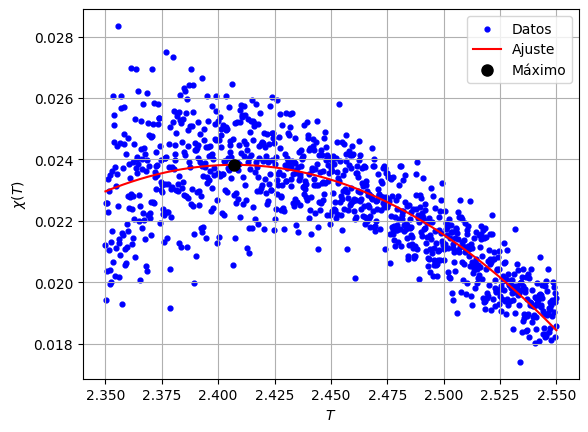

Parámetros de ajuste:
a: a=-0.26414642346988415 ± 0.012249659243122815
b: b=2.407195918932752 ± 0.002318812009902973
c: c=0.023821995095641587 ± 4.9141760834710375e-05
Máximo: T = 2.407195918932752, chi = 0.023821995095641587


In [ ]:
popt, pcov = curve_fit(cuadratica, T, suscep_15)            # Ajusto
perr       = np.sqrt(np.diag(pcov))                         # Ploteo y calculo errores
a_fit_15, b_fit_15, c_fit_15 = popt                         # Extraigo los parámetros de ajuste
a_err_15, b_err_15, c_err_15 = perr
ajuste_15  = cuadratica(T, a_fit_15, b_fit_15, c_fit_15)
T_15       = maximo(a_fit_15, b_fit_15)                     # Hallo el máximo
chi_15     = cuadratica(T_15, a_fit_15, b_fit_15, c_fit_15) # Valor de la cuadrática en T_max

plt.scatter(T, suscep_15, color='blue', s=12, label='Datos')
plt.plot(T, ajuste_15, 'r-', label='Ajuste')
plt.plot(T_15, chi_15, 'go', color='black', markersize=8, label='Máximo')
plt.xlabel('$T$', fontsize = 10)
plt.ylabel('$\chi(T)$', fontsize = 10)
plt.grid()
plt.legend()
plt.show()
print("Parámetros de ajuste:")
print(f"a: a={a_fit_15} ± {a_err_15}")
print(f"b: b={b_fit_15} ± {b_err_15}")
print(f"c: c={c_fit_15} ± {c_err_15}")
print(f"Máximo: T = {T_15}, chi = {chi_15}")

Debido a que el máximo de la cuadrática está dado por la expresión:

$$x_{\text{max}} = -\dfrac{b}{2a},$$

(donde en nuestro caso la coordenada $x_{\text{max}}$ representa el máximo en la temperatura), voy a hallar su incerteza mediante la fórmula de propagación de errores, colocando los errores de los parámetros $a$ y $b$ de la cuadrática dados por el ajuste.

La fórmula de propagación general es:

$$\Delta f(x_1,\dots,x_n) = \sqrt{\sum\limits_{i=1}^{N} {\left[{\dfrac{\partial f}{\partial x_i}(x_1,\dots,x_n) \Delta x_i}\right]}^2},$$

por lo que la incerteza de la temperatura máxima resulta:

$$\Delta T = \sqrt{\dfrac{b^2}{4a^4} \Delta a^2 + \dfrac{1}{4a^2} \Delta b^2}.$$

Con esta fórmula, definí la función error_T al comienzo de la sección.

In [ ]:
delta_T_15 = b_err_15
print("La temperatura máxima es:")
print(f"T = {T_15} ± {delta_T_15}")

La temperatura máxima es:
T = 2.407195918932752 ± 0.002318812009902973


Luego, repito todo el procedimiento para las distintas redes.

### L = 30

In [ ]:
L    = 30                         # Lado de la red
N    = 10000                      # Número de pasos para llegar al equilibrio
S    = np.ones((L,L),dtype=int)
T    = np.linspace(2.2,2.45,1000) # Creo una lista de valores de T bajos y cercanos al equilibrio
beta = 1/T                        # Creo el vector beta

In [ ]:
suscep_30 = [] # Creo una lista vacía para hallar los datos de susceptibilidad

for x in tqdm(beta):                         # Para los valores de beta, termalizamos, calculamos el valor medio de energía y magnetización.
  prob=np.array([np.exp(-4*x),np.exp(-8*x)])
  for n in range(N):
    S,dm,de=metropolis(S,prob)               # Termalizamos con metrópolis
  m=np.zeros(N)
  e=np.zeros(N)                              # Magnetizacion y energia por particula en funcion del paso
  m[0]=np.mean(S)
  e[0]=h(S)
  mmedia=[abs(m[0])]
  emedia=[e[0]]                              # Valores medios en funcion del numero de pasos para promediar
  for n in range(1,N):
    S,dm,de=metropolis(S,prob)
    m[n]=m[n-1]+dm
    e[n]=e[n-1]+de
    mmedia.append(np.mean(abs(m[0:n+1])))
    emedia.append(np.mean(e[0:n+1]))
  suscep_30.append(x*(np.std(abs(m))**2))
print(suscep_30)

100%|██████████| 1000/1000 [56:15<00:00,  3.38s/it]

[0.003417914927048261, 0.002687726782916378, 0.00637223314379291, 0.010127046777072764, 0.0023129047235049445, 0.0064925970294124, 0.005590343236443084, 0.005995022896382138, 0.0036534785453629, 0.0021825342316232244, 0.001913507692026842, 0.0029814147207634393, 0.0032528002267072564, 0.009013196218924595, 0.002882442970882051, 0.007169957412913658, 0.004497419811976843, 0.0037370504018395118, 0.003297947958360497, 0.002345927632817722, 0.004630504176616427, 0.0025881055775844107, 0.004871155704699288, 0.003022871435316053, 0.004148955794998343, 0.002303248665970972, 0.0026074053743731125, 0.004931838786114786, 0.004005743005555724, 0.0041605892110999935, 0.003372982008284277, 0.004000834983484385, 0.004374091928068424, 0.004043075274647441, 0.004100499103722976, 0.0026688237250652143, 0.010588116948265967, 0.0029370515652416837, 0.008827464616878581, 0.012566509694150848, 0.0024948006721671615, 0.001939453665627732, 0.0038995567060194115, 0.007674011018918895, 0.0023009499026608693, 0

##### Vector suscep_30

In [ ]:
suscep_30 = [0.003417914927048261, 0.002687726782916378, 0.00637223314379291, 0.010127046777072764, 0.0023129047235049445, 0.0064925970294124, 0.005590343236443084, 0.005995022896382138, 0.0036534785453629, 0.0021825342316232244, 0.001913507692026842, 0.0029814147207634393, 0.0032528002267072564, 0.009013196218924595, 0.002882442970882051, 0.007169957412913658, 0.004497419811976843, 0.0037370504018395118, 0.003297947958360497, 0.002345927632817722, 0.004630504176616427, 0.0025881055775844107, 0.004871155704699288, 0.003022871435316053, 0.004148955794998343, 0.002303248665970972, 0.0026074053743731125, 0.004931838786114786, 0.004005743005555724, 0.0041605892110999935, 0.003372982008284277, 0.004000834983484385, 0.004374091928068424, 0.004043075274647441, 0.004100499103722976, 0.0026688237250652143, 0.010588116948265967, 0.0029370515652416837, 0.008827464616878581, 0.012566509694150848, 0.0024948006721671615, 0.001939453665627732, 0.0038995567060194115, 0.007674011018918895, 0.0023009499026608693, 0.0034202279892158664, 0.0029003548405226367, 0.006184633594295634, 0.004512400494453804, 0.0036252269803174935, 0.004655685244054346, 0.009669513773222052, 0.003068382286729982, 0.0053076063118922085, 0.007618021361616556, 0.004023066277453653, 0.0035249659034168224, 0.0054027445266324435, 0.003407694396988344, 0.02044566541621384, 0.012998104194737915, 0.00408566427851454, 0.005413093814465283, 0.0047031807439783715, 0.005885705778344989, 0.004274864172093685, 0.002312914795771728, 0.00627535780741007, 0.0032261356650815716, 0.007663679763029017, 0.0038782542123998376, 0.00839409489133201, 0.0021775224765622657, 0.006441077910929798, 0.004776423275214244, 0.009155672593199946, 0.003567211741924086, 0.0036790758371246985, 0.006400368973513153, 0.0096389870651046, 0.0152489112127231, 0.013320780630133111, 0.0121079601111019, 0.0071009190640992205, 0.0027798788238687774, 0.006101971663623633, 0.0028337760536787976, 0.006194538663062281, 0.003026516991610649, 0.003762937249138832, 0.006966136205153647, 0.01042581399586409, 0.005163083071745906, 0.002670373173905436, 0.011386705927785828, 0.006556565675792099, 0.006883948595968408, 0.003234865549468892, 0.010958814779087769, 0.01782763491249361, 0.003932636845825081, 0.007356325174168767, 0.00483407740426392, 0.005843327976630147, 0.010901450433640342, 0.024920988758998498, 0.005202681787496885, 0.00772213422248277, 0.010168653532735817, 0.005883011531634794, 0.006658465737190824, 0.006242436232950917, 0.012771311171708785, 0.00813524265115818, 0.01125648620107081, 0.0036595488404973448, 0.0042353933328800625, 0.0075883489907138885, 0.009832104669809499, 0.0054303701311952625, 0.004757811735528029, 0.008145358032764097, 0.006800857705484293, 0.006698130274382879, 0.020454329490902153, 0.0054842587276642575, 0.00847061015497959, 0.011633127770794978, 0.01228085156737524, 0.012849124618378947, 0.00494556692443467, 0.010651817437127157, 0.004193708410323341, 0.00877075725295744, 0.010491351587939417, 0.026099337871229564, 0.012766775106416332, 0.0054628466730882504, 0.0051043596104006295, 0.012795927627584592, 0.005899684682672276, 0.011507714248731257, 0.004180438408578036, 0.006086113467021863, 0.006647901610626394, 0.0041826193143919355, 0.009263961705933224, 0.003741475092314197, 0.0049737631332450365, 0.00421140711666405, 0.007792570496268638, 0.004286414583497265, 0.006748173564106503, 0.004171757160365822, 0.012772802164592095, 0.006797529997838929, 0.00471520610621841, 0.003435766436731112, 0.004351509346460465, 0.015347916270398639, 0.009943365228989785, 0.011532929558030116, 0.024447408275253518, 0.01062649770269922, 0.009867137408537285, 0.008303726493219858, 0.006562702553662318, 0.010974498327921864, 0.008485611138081965, 0.006128215926846885, 0.00413489097686499, 0.0045209459841366335, 0.008562893177857307, 0.011864572331726657, 0.012520600232224144, 0.010639918541516353, 0.006118098022974418, 0.009514927693782045, 0.010930273304105571, 0.007682976878102765, 0.009070529824430806, 0.010776870737708565, 0.003892805294588029, 0.014247670670549153, 0.009762865294499181, 0.010847614311426234, 0.024398517375886723, 0.013429529724813146, 0.005170772080424671, 0.005420663004118985, 0.009017273619308487, 0.004769525414348656, 0.01007034047789824, 0.01690874928635478, 0.005190274554130795, 0.01133164130023844, 0.009595883218611935, 0.006103452324142327, 0.013112818584768647, 0.010148291078772825, 0.01901712913825252, 0.010748181812563528, 0.003710196585741516, 0.005485819724383563, 0.01298475035733131, 0.003392149152084653, 0.009560480416942763, 0.011643673097456843, 0.015141006108197474, 0.013162101420067943, 0.00860132196709057, 0.006091557724882061, 0.006585241356414308, 0.009171499633997198, 0.01122161914416738, 0.019019695075059753, 0.009091940894139226, 0.012453080671212442, 0.006317785966153116, 0.018036633455833347, 0.008059237243515056, 0.016384507453039508, 0.010640379571997798, 0.005562832834586606, 0.008844992092848789, 0.006407370768387567, 0.010841168044175143, 0.0159883395836525, 0.010424412796799122, 0.01302307641218185, 0.014032113758058505, 0.006448582793952704, 0.007028272676700073, 0.006403738673420068, 0.009655382722451198, 0.005887561052856811, 0.006541684364874744, 0.009478143452077136, 0.013654924720865953, 0.015807415656323598, 0.00829301353552838, 0.008759398241874132, 0.007578608332329602, 0.02518644415580794, 0.0133793418593017, 0.011773652734379483, 0.016298380531012898, 0.008994655822284434, 0.015389731224990362, 0.011862941238763178, 0.013825946113819721, 0.008180789174143674, 0.025239684900284897, 0.01521705077719172, 0.015008605089079826, 0.01043508426294471, 0.014323258719412231, 0.012602914624405876, 0.00827918334100813, 0.011094912992183183, 0.010619494783682794, 0.007625138174721738, 0.012330561352316227, 0.012736039549243162, 0.014945912060940083, 0.005901140665286812, 0.022184360925711827, 0.020812366574720877, 0.02415136954378606, 0.01950148874553583, 0.015096470236609169, 0.011902048015565261, 0.01764571723127784, 0.008929122906599597, 0.017916008296543825, 0.00975289804234512, 0.020191779575617255, 0.011795221767934554, 0.015137094591360081, 0.01050351311295865, 0.006617103756138421, 0.01207194242655319, 0.007606101272545959, 0.022393878206685394, 0.019368218720072283, 0.015094875792660964, 0.013792595802641045, 0.013053440788331297, 0.018548710521734808, 0.00972980931506764, 0.00574835997245121, 0.01651906726355169, 0.010400078188636584, 0.012877659907037473, 0.019578026295704338, 0.010405871424115963, 0.015016604511270347, 0.014391557017511597, 0.00889116752746147, 0.007035656309941401, 0.014904382866603286, 0.01186212377377647, 0.018794088691815425, 0.011594051758226531, 0.010697304031015278, 0.01725938211705808, 0.017826525957354213, 0.018420490513195872, 0.01932489080773401, 0.02188777877203462, 0.012935901836754122, 0.013729613270079514, 0.017380324076727936, 0.014043098085300925, 0.010995047146540086, 0.021101436286017603, 0.013309355629128604, 0.013608346014502976, 0.012111311020338694, 0.016637152536546164, 0.008870417694235995, 0.025447350306138938, 0.009823196562669247, 0.014221836127171497, 0.013962113278958552, 0.012595831487884904, 0.014616302823704377, 0.014379486235793852, 0.015554938531475281, 0.013154670296474229, 0.010920015239063274, 0.008585041233285554, 0.013601412313618043, 0.013060592262038356, 0.015423754481903496, 0.017898868415222396, 0.011660906555574778, 0.013872413464153173, 0.013893202270231471, 0.01641895649737468, 0.009344481245489736, 0.015345104897622062, 0.01888493612741794, 0.012398424595432505, 0.020247542627893342, 0.020073837541692435, 0.01905671658694863, 0.01528160020662388, 0.02594029849453025, 0.008683083902569624, 0.008587821758004063, 0.02394369058304974, 0.01688456842691101, 0.016155434229212187, 0.018124422306485293, 0.02533777551840115, 0.009653328269177901, 0.013106297490171157, 0.011492326176777819, 0.02464386172660595, 0.015548174363325461, 0.017397088272131035, 0.009550384020388956, 0.015744206467409778, 0.015782338206470955, 0.023318092862350783, 0.018670918202114202, 0.012611158959082217, 0.023112601409555573, 0.016806166165074743, 0.020969804030392978, 0.01890611695506493, 0.01567700038949998, 0.017342047446255626, 0.013408018381122787, 0.01793390019859916, 0.017501871976869983, 0.016771575916872058, 0.017682120777378116, 0.018896306982279152, 0.016098916043141974, 0.017319174251974122, 0.011387557662582317, 0.013390495555909359, 0.013950438827184585, 0.02038482264055444, 0.01586754189064949, 0.013262617963078862, 0.01260049565767707, 0.015000447587459931, 0.019202435454033273, 0.012911861083860516, 0.02259032300561142, 0.01530514186897785, 0.023617628300940906, 0.015079516747977018, 0.023734361923280527, 0.014250936439970099, 0.018103612587955134, 0.016455885340429587, 0.014445085277460796, 0.016323245903421293, 0.010673245608483362, 0.022483266550571965, 0.015597691480727902, 0.020890004074320602, 0.01644999482319664, 0.015343546683293123, 0.01551283556334924, 0.020028044865428793, 0.014711605974944128, 0.012005437560974608, 0.027292438388777825, 0.0164468628355878, 0.012805521174030377, 0.02378299233711947, 0.02154640817700232, 0.016903937054292197, 0.015108321965410237, 0.02370787187727636, 0.023292748071955836, 0.019557952022140456, 0.017136032172183697, 0.020688500098515743, 0.018863979709282067, 0.02218722249721549, 0.01871727684963879, 0.02173038248368775, 0.014612984316714197, 0.02011824391841806, 0.017925686129705146, 0.022864165228723123, 0.018900638698035672, 0.01429916103580753, 0.017993939667836238, 0.020727280020340876, 0.017260176082119535, 0.02203696660950746, 0.025649806654036034, 0.023961879053092706, 0.02221111438443544, 0.02169545577442599, 0.01849113171057026, 0.018529988703948407, 0.017975674331538485, 0.02090846497256443, 0.020284768001156406, 0.01898860751325295, 0.020045885882892044, 0.02401668754360299, 0.010824049375867485, 0.01714614240807194, 0.022495186052006268, 0.017958459749087833, 0.021486799309527335, 0.0242201958299883, 0.014830602783310597, 0.021156940919653228, 0.018931020690457146, 0.013857223242261013, 0.02081373139820309, 0.02124734398690499, 0.02042631567088168, 0.018636496639702033, 0.01734757261488922, 0.014384322156106253, 0.023593930262470735, 0.017524739761763337, 0.016121264967011103, 0.019888260356667346, 0.019760998632348856, 0.020179163417755046, 0.020922623088176995, 0.015044568078597605, 0.022786047578801243, 0.02122903037188229, 0.023205450653506005, 0.020820422551705575, 0.02203763580376471, 0.018863350790004944, 0.013384281521403616, 0.013498973996041476, 0.019968637297265602, 0.02530884375105015, 0.01887887936597263, 0.01942994521213547, 0.01886876864365863, 0.016167893787472035, 0.011460129077349758, 0.016988240649794602, 0.018705110746196685, 0.016157394040943157, 0.021284171675128166, 0.021161723930165546, 0.023981960043862147, 0.021727716131435152, 0.018182222805471045, 0.021102712516210466, 0.024923238611835947, 0.022261935839342148, 0.01846266747088394, 0.014181186877896438, 0.019998437706097414, 0.021556877391964862, 0.01975146017052702, 0.019551601389936748, 0.02230345316047842, 0.019948642155613074, 0.02027931074166551, 0.018165669850246733, 0.015156584536403915, 0.02160010502651439, 0.021673588096590722, 0.020515565237544015, 0.022904154874416868, 0.020121642448479745, 0.02417737450755375, 0.01777212090767395, 0.020827852099607854, 0.01965522554267107, 0.02238183171556949, 0.019518282378097274, 0.019777013948513607, 0.021079291969355474, 0.016130446465963604, 0.018136655634888074, 0.02395541298568496, 0.02424738024503327, 0.02042702959934299, 0.015731662591235946, 0.022850964937580022, 0.022145249704222603, 0.021626614175277722, 0.022256897706929204, 0.02195620772570554, 0.017575138382163513, 0.016696809720263665, 0.021395695276335138, 0.019732758376759387, 0.025215260388938062, 0.018480092514903415, 0.015977965702720004, 0.025311722330643563, 0.020143374956020896, 0.020316512600110272, 0.021184780914983558, 0.016940810832364907, 0.02313463188558144, 0.019553965605118465, 0.02264044020400024, 0.0191797504541732, 0.022718222848629198, 0.01678411095167965, 0.022899051617917388, 0.020461588387135222, 0.01612442947730799, 0.017913834979273544, 0.01984509375934506, 0.021482488630372942, 0.022251484618250186, 0.02075270085901161, 0.019503760909551134, 0.019967021097097307, 0.020536732050814983, 0.021058874250441825, 0.02276982915668444, 0.017261589215784225, 0.021298839818112123, 0.018034009749338702, 0.01808604886901157, 0.018720511580680575, 0.020753496361526427, 0.0206088518630098, 0.020356919787999347, 0.02141863828595056, 0.018036367243228928, 0.01931102345022352, 0.02127814620427013, 0.015192138807626735, 0.021393212163293814, 0.017554348480091096, 0.023774509127661197, 0.02037531161318823, 0.018197431419968192, 0.01994087031304606, 0.018035524104292367, 0.019223000702112674, 0.01901302457138586, 0.01954078898323832, 0.01947715128436326, 0.019780317919371695, 0.016986063325754107, 0.021875622658065173, 0.02047203305363311, 0.018071000327101128, 0.020842667157069995, 0.01889380408588319, 0.02266543371581462, 0.019538083186621823, 0.02089536786867162, 0.01439386271085669, 0.021362149704791642, 0.016973614738075526, 0.021713578857351704, 0.019721288695440504, 0.018500447388050505, 0.018918967859177887, 0.018998505953458884, 0.01999654559556731, 0.017549873779472973, 0.015911745551071145, 0.018924129322041225, 0.020517065513867647, 0.018512556037834475, 0.015212517473716939, 0.019518921126560243, 0.014943531949244507, 0.01847193490179884, 0.02026962653549971, 0.018369639612532775, 0.020167350247527447, 0.02022439532639179, 0.02051585231842487, 0.017696868773468728, 0.021327829623512647, 0.020885386853254133, 0.01969710047234534, 0.021497745431894283, 0.019279647440274068, 0.016047256553254716, 0.018824343837982423, 0.019601132024134743, 0.02127628278988471, 0.02347877363313626, 0.020050699671729406, 0.018758925679722156, 0.018385058782355683, 0.02091856718016617, 0.018907025084178228, 0.018277298734288835, 0.02098983426544976, 0.01843480266067691, 0.02057536402659088, 0.018571846285965535, 0.019647996129347086, 0.01876512808070365, 0.02140738114150399, 0.020964626079991472, 0.01799230693622792, 0.01914186385140143, 0.01945037812926773, 0.021841187992542987, 0.02014517126584658, 0.019957366582601242, 0.019273487827186755, 0.01999265039434551, 0.01715128700163829, 0.02039223495153334, 0.02005709688608105, 0.018635668968192826, 0.019118961666695997, 0.018520941459578662, 0.02093552129356032, 0.01844901186058368, 0.018063182726612555, 0.01805178391456855, 0.01868197296557117, 0.017975131125372693, 0.02156987813811623, 0.0187013743174777, 0.020801468061750067, 0.01840276291189501, 0.020318294566521768, 0.01658363882741954, 0.019502413644757396, 0.018762396254298732, 0.016892468125360795, 0.018946850818177326, 0.017842723837086984, 0.017851026585126405, 0.017628718753723516, 0.019801665660817907, 0.02013728868689047, 0.01816331844048773, 0.019940654756978496, 0.019395627402833515, 0.020601260729255066, 0.016542076197191866, 0.01789852404698396, 0.020984181414317276, 0.01937626479354905, 0.02036568882153197, 0.015231116558798696, 0.019950871505697496, 0.019460519318366596, 0.021147755104269035, 0.020661018955635404, 0.01567773716390357, 0.020264439409938023, 0.019381642149122264, 0.019845639489386384, 0.018202479858335296, 0.015126371934587267, 0.01877465165582752, 0.02051230198613086, 0.01896590887762149, 0.01867718491232954, 0.01689936788195657, 0.01763983728250351, 0.018768129959488282, 0.018922219952030216, 0.019338522621577883, 0.020149141899443283, 0.016878344323660425, 0.017438845358696487, 0.01755405003814327, 0.018094589629592723, 0.0178196750242236, 0.019217301036922565, 0.019478102105168177, 0.015453266746221996, 0.018462341620283824, 0.017226070761721647, 0.020254131072576696, 0.017695809753238048, 0.019215370406149793, 0.017144655594369722, 0.017102985232039656, 0.01774481604661457, 0.017051821761473906, 0.01815628363231529, 0.017156924832433952, 0.016362989023682797, 0.016736397856580362, 0.018306250237265387, 0.01640906536638353, 0.016875114640447293, 0.01634847203445095, 0.017261326155221392, 0.01852113135742405, 0.016240731312629392, 0.019627720541924583, 0.01965393829771047, 0.018645016582753755, 0.01577047177378586, 0.01879181090214663, 0.017095540111869027, 0.01667335942624652, 0.019125425714585118, 0.02063263812682723, 0.018260288316160368, 0.01651877690269219, 0.01667109662098084, 0.016945288806465387, 0.017615178012503018, 0.0149377249186136, 0.018245079151428423, 0.017402521750292606, 0.015137411787751845, 0.014612057974004016, 0.017509186761318365, 0.019645055582749094, 0.019037622321972373, 0.017133772947014167, 0.01612858394249385, 0.014814510609805574, 0.01933877714737926, 0.017951976559688117, 0.018004632897192504, 0.017328748397564934, 0.017603755304173782, 0.017971106519624885, 0.017407023712566565, 0.01457412209399946, 0.01679324821498374, 0.01571484661005459, 0.016594891469116684, 0.018258615106965727, 0.018344086192683767, 0.01554895568680393, 0.015371815603884962, 0.013236821632874107, 0.01700193836734662, 0.01668099670990395, 0.017235933642912506, 0.016548232132989726, 0.016492426080213805, 0.018759868723935633, 0.0177714261660726, 0.017285606299800065, 0.01620029775207732, 0.01839633614177843, 0.016685660055764245, 0.01798567841503746, 0.018003076816329105, 0.017569223549511907, 0.016987374091918122, 0.013922771400772884, 0.01600970790073717, 0.017793664260044844, 0.014121279067702615, 0.017108443957442137, 0.017295744328303667, 0.018829891456614456, 0.014369181088270252, 0.018628761355147495, 0.017499615150970153, 0.01620445631508797, 0.015696819418880483, 0.01830875697393357, 0.017836772602062533, 0.016614521023413768, 0.014679584198162801, 0.01655428958068789, 0.01631823893117615, 0.016276685919123325, 0.012462968590224005, 0.016354477814893065, 0.0172265130774136, 0.01570008681370878, 0.01548740448088508, 0.014392229742974954, 0.015913691104358172, 0.01598011318841549, 0.015485571455968117, 0.014261235746622, 0.013910377288185349, 0.017443558000221817, 0.01533223531090707, 0.015578040192446158, 0.013701675482573231, 0.015131797572932043, 0.0145639457587203, 0.011525184572358845, 0.013818649341271928, 0.01657336011432515, 0.01444126117116781, 0.016316405264608556, 0.01849400289546128, 0.014592564074641854, 0.01517744634356285, 0.016630054477588682, 0.01511524179116277, 0.015096225459017268, 0.014425132285550223, 0.015593670208205433, 0.015019412194251165, 0.01575720382402082, 0.013237979864236561, 0.015005484580711043, 0.013748951571390595, 0.014802623708876925, 0.01717755072933297, 0.016350718757632842, 0.0137484957737558, 0.012833709146012598, 0.01703025245339471, 0.015329382301509493, 0.016974407892588257, 0.016616459363858138, 0.015154580550134264, 0.01667967679057731, 0.01591431238542136, 0.01759478758090888, 0.015016594294583947, 0.015535186600484682, 0.015709565995761312, 0.015210687576736553, 0.015948360396779864, 0.014732523197495148, 0.016394638213007646, 0.016009002845287144, 0.014880402764976694, 0.014541172148861163, 0.01469520791972957, 0.013112370138254958, 0.015721104579823446, 0.015188202192216688, 0.013851964465519387, 0.016419281848330195, 0.012987295782715408, 0.013713079071300139, 0.014890706571438888, 0.013109107029645602, 0.014316437958036983, 0.016054450169377777, 0.012929621700594952, 0.01280591393953421, 0.013966421797981658, 0.015438176750177343, 0.015439457852074534, 0.01716447424505614, 0.012532963083099232, 0.01591925135263461, 0.014923019866301589, 0.01329150673019344, 0.014313409202302983, 0.013050304250028956, 0.01328408385644939, 0.013514769246269686, 0.01404860838988879, 0.013551882975017986, 0.014173617212444187, 0.013900837868131705, 0.01488239103831891, 0.012876961219739405, 0.014989136384702116, 0.011492301122009978, 0.012915590626127245, 0.01624526872692219, 0.011685324428359374, 0.01591075957682457, 0.014599271724553806, 0.013649442832999034, 0.012383400461337292, 0.015589911796679803, 0.017224712173342115, 0.013403201958026946, 0.014931836876302614, 0.013579380786777891, 0.013248112697256786, 0.01324195340846905, 0.013287463159727668, 0.01254750068525113, 0.012657448764617297, 0.013822234225214508, 0.014265211156325943, 0.0133113555036738, 0.013567234071143335, 0.01401150027938957, 0.014965165493526464, 0.013346002346729743, 0.013501009169162411, 0.01230564540609365, 0.01493825725985164, 0.014959332309551815, 0.0153557623525767, 0.01313143882879326, 0.011908065688282963, 0.013964106005912587, 0.01371892836744656, 0.012899375850049412, 0.010938081519214252, 0.013730457097793738, 0.013218907383571923, 0.01116291462784357, 0.014005153132781242, 0.01376511261162405, 0.013485924597137048, 0.0129694506743122, 0.01390108338174186, 0.010657492661725958, 0.011906938188546956, 0.010181593875674149, 0.011691602279234912, 0.0126657027747742, 0.014151679494348866, 0.012427872012579218, 0.01286422747175865, 0.011227409731983344, 0.015376997322849575, 0.014347236613655978, 0.01143356744884168, 0.012555715420429924, 0.01364298032019845, 0.013403772252794053, 0.013052564313963302, 0.011513117092202528, 0.012778184393367224, 0.013346919822617294, 0.014200551597799739, 0.014477655632589936, 0.013675769814532392, 0.013593578657811457, 0.011311838339177217, 0.013120107101487179, 0.013960095730478605, 0.012552953735005153, 0.012119196290580165, 0.013951274782611064, 0.012350462145666185, 0.011957041007444531, 0.010943815091704938, 0.012291797185047986, 0.013060612531583055, 0.01191427002945819, 0.011469030299252949, 0.012295819513190837, 0.011158496673182803, 0.01379999768199261, 0.013006580323436793, 0.012745100646923064, 0.013017652057840655, 0.011342500001145795, 0.010895702972961632, 0.0125891347974969, 0.01418002571560133, 0.011657660890289391, 0.01268864296456669, 0.011392558052587555]


##### Ajuste

<ipython-input-39-fc53f9f3bb57>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(T_30, chi_30, 'go', color='black', markersize=8, label='Máximo')


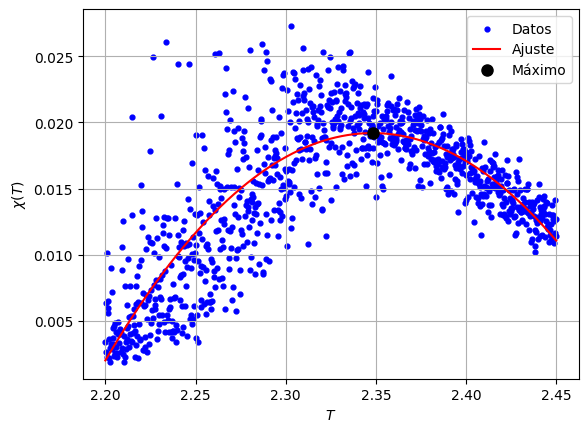

Parámetros de ajuste:
a: a=-0.7824874589315134 ± 0.02162754398484967
b: b=2.3481387780233263 ± 0.0010983526207888053
c: c=0.019198343113100643 ± 0.00014661726664981365
Máximo: T = 2.3481387780233263, chi = 0.019198343113100643


In [ ]:
popt, pcov = curve_fit(cuadratica, T, suscep_30)            # Ajusto
perr       = np.sqrt(np.diag(pcov))
a_fit_30, b_fit_30, c_fit_30 = popt
a_err_30, b_err_30, c_err_30 = perr
ajuste_30  = cuadratica(T, a_fit_30, b_fit_30, c_fit_30)
T_30       = b_fit_30
chi_30     = cuadratica(T_30, a_fit_30, b_fit_30, c_fit_30) # Valor de la cuadrática en T_max

plt.scatter(T, suscep_30, color='blue', s=12, label='Datos')
plt.plot(T, ajuste_30, 'r-', label='Ajuste')
plt.plot(T_30, chi_30, 'go', color='black', markersize=8, label='Máximo')
plt.xlabel('$T$', fontsize = 10)
plt.ylabel('$\chi(T)$', fontsize = 10)
plt.grid()
plt.legend()
plt.show()
print("Parámetros de ajuste:")
print(f"a: a={a_fit_30} ± {a_err_30}")
print(f"b: b={b_fit_30} ± {b_err_30}")
print(f"c: c={c_fit_30} ± {c_err_30}")
print(f"Máximo: T = {T_30}, chi = {chi_30}")

In [ ]:
delta_T_30 = b_err_30
print("La temperatura máxima es:")
print(f"T = {T_30} ± {delta_T_30}")

La temperatura máxima es:
T = 2.3481387780233263 ± 0.0010983526207888053


### L = 60

In [ ]:
L    = 60                          # Lado de la red
N    = 20000                       # Número de pasos para llegar al equilibrio
S    = np.ones((L,L),dtype=int)
T    = np.linspace(2.25,2.45,1000) # Creo una lista de valores de T bajos y cercanos al equilibrio
beta = 1/T                         # Creo el vector beta

In [ ]:
suscep_60 = [] # Creo una lista vacía para hallar los datos de susceptibilidad

for x in tqdm(beta):                         # Para los valores de beta, termalizamos, calculamos el valor medio de energía y magnetización.
  prob=np.array([np.exp(-4*x),np.exp(-8*x)])
  for n in range(N):
    S,dm,de=metropolis(S,prob)               # Termalizamos con metrópolis
  m=np.zeros(N)
  e=np.zeros(N)                              # Magnetizacion y energia por particula en funcion del paso
  m[0]=np.mean(S)
  e[0]=h(S)
  mmedia=[abs(m[0])]
  emedia=[e[0]]                              # Valores medios en funcion del numero de pasos para promediar
  for n in range(1,N):
    S,dm,de=metropolis(S,prob)
    m[n]=m[n-1]+dm
    e[n]=e[n-1]+de
    mmedia.append(np.mean(abs(m[0:n+1])))
    emedia.append(np.mean(e[0:n+1]))
  suscep_60.append(x*(np.std(abs(m))**2))

print(suscep_60)

100%|██████████| 1000/1000 [7:07:19<00:00, 25.64s/it]

[0.0071151028667596344, 0.014508119153923953, 0.0024642566856514993, 0.008953314978882625, 0.009790360598506125, 0.009795823940273092, 0.0061849821884730795, 0.005420545281753931, 0.0026830537066678786, 0.00903756482391034, 0.0069854427970086055, 0.003806944645636637, 0.009321802595614598, 0.0034221302656429987, 0.004666221319129762, 0.003252058493721601, 0.010197147888069628, 0.004404746039819163, 0.020781214262866523, 0.005054824510458242, 0.004189344129895564, 0.006797080364764031, 0.002142720062076543, 0.004200338392974063, 0.008841086117433063, 0.01985026617853176, 0.007123337231304048, 0.011115616530296704, 0.00767274892582686, 0.01039671748686406, 0.014150429684247309, 0.002300763240429043, 0.0073891239215520856, 0.009421803036878482, 0.008947498950107416, 0.011166094093564281, 0.006675470554409907, 0.013036338676374038, 0.0023357806771202843, 0.004672133549522983, 0.010616954191376912, 0.004805621673150214, 0.007343437803590166, 0.006295730905711251, 0.010747640528223548, 0.007

##### Vector suscep_60

In [ ]:
suscep_60 = [0.0071151028667596344, 0.014508119153923953, 0.0024642566856514993, 0.008953314978882625, 0.009790360598506125, 0.009795823940273092, 0.0061849821884730795, 0.005420545281753931, 0.0026830537066678786, 0.00903756482391034, 0.0069854427970086055, 0.003806944645636637, 0.009321802595614598, 0.0034221302656429987, 0.004666221319129762, 0.003252058493721601, 0.010197147888069628, 0.004404746039819163, 0.020781214262866523, 0.005054824510458242, 0.004189344129895564, 0.006797080364764031, 0.002142720062076543, 0.004200338392974063, 0.008841086117433063, 0.01985026617853176, 0.007123337231304048, 0.011115616530296704, 0.00767274892582686, 0.01039671748686406, 0.014150429684247309, 0.002300763240429043, 0.0073891239215520856, 0.009421803036878482, 0.008947498950107416, 0.011166094093564281, 0.006675470554409907, 0.013036338676374038, 0.0023357806771202843, 0.004672133549522983, 0.010616954191376912, 0.004805621673150214, 0.007343437803590166, 0.006295730905711251, 0.010747640528223548, 0.00790514622857695, 0.011451187275201998, 0.017556185977260236, 0.003557324096066801, 0.0029928809932233593, 0.017261971708327748, 0.01194683523282269, 0.00786685293473904, 0.01795255993148318, 0.0039182587774558445, 0.0056436382013235415, 0.0075067573630887155, 0.005286561374510319, 0.01606753861028132, 0.00996309693307533, 0.003317403752023488, 0.018041155400860286, 0.003734742600148201, 0.006591648367697526, 0.013499002127939549, 0.0033786344164345138, 0.010019668132558269, 0.006719365719860362, 0.005978325285383291, 0.006026619190957778, 0.0031769187552067573, 0.017877012232030434, 0.01123553650170831, 0.011636895832297224, 0.006544394630384289, 0.01461131183270675, 0.012005869157381768, 0.014335972181214234, 0.01192082628931373, 0.00809877214208902, 0.01148928235369869, 0.0032307917766026878, 0.016425684453263936, 0.007355406402146713, 0.015077662987024669, 0.014480387551293184, 0.01043291628184611, 0.007364640805909686, 0.004577201059662393, 0.00501418722148687, 0.014508741984636959, 0.017310305806005365, 0.008937260561791916, 0.007596580408812151, 0.008328021653921415, 0.020680627603609083, 0.008487290302196061, 0.0157072643402924, 0.010319986854192054, 0.011761396140808612, 0.018853720736813094, 0.01147291921695348, 0.011541800017960015, 0.006960675893623599, 0.018241846609026564, 0.011477683195594227, 0.017135091656617106, 0.002971659546529001, 0.015354271291730915, 0.006275280084057369, 0.016262603301398264, 0.005078600731795389, 0.01610921372711149, 0.021992298830653893, 0.010630872634610905, 0.015640250707782605, 0.015309983793138604, 0.004259315092622388, 0.010518833412579608, 0.009468917054437026, 0.010455682553975016, 0.010085379227631919, 0.0034164877578321336, 0.005706643415201684, 0.007735916135197531, 0.019509071857354496, 0.007359138135552496, 0.009158157637313473, 0.0071496566963695505, 0.014844056457962945, 0.012705771852031393, 0.007428079353401903, 0.01779424204161411, 0.009973557179797076, 0.013605401994596771, 0.007990419803154203, 0.019405499629663252, 0.021487526393460247, 0.006037469083593367, 0.006197760067380047, 0.015295446713065873, 0.019194047710222446, 0.01617301290315767, 0.017222112180026037, 0.020324730305912017, 0.009861280568093775, 0.019261645056040066, 0.007353195725514206, 0.004413664670192265, 0.015627021188570744, 0.013569148910082526, 0.012529027065064412, 0.007830803830423474, 0.010442734271604595, 0.009821945566169553, 0.00405985844215336, 0.010134418476902026, 0.009333444277767187, 0.010776034645167382, 0.014839029291893457, 0.02178120857722487, 0.018129392474259425, 0.01691862393672999, 0.016160132701393982, 0.01656923523313709, 0.008851555245069254, 0.016045390846246933, 0.025372562653629502, 0.012531970275371906, 0.015853051460838076, 0.01112904502762576, 0.015362155150039762, 0.020510060841811565, 0.020083305974477602, 0.012939200950726575, 0.0076920029752024855, 0.009550107672632148, 0.01684803815874088, 0.013974738419174825, 0.012326220877353307, 0.023742619727465386, 0.02160849854041995, 0.013096792016022414, 0.0191272032511498, 0.017272533006471476, 0.01453245555480395, 0.01230688358616604, 0.011513539798668614, 0.019422075029664174, 0.015066521903507227, 0.021011288469601923, 0.012508025202425357, 0.011491398179522092, 0.01681916234849125, 0.007784980753353739, 0.01519302615792813, 0.014493737135811197, 0.01538724859094174, 0.012816298689002848, 0.013302483576784038, 0.018007507732140025, 0.02364777009495916, 0.010158867714915237, 0.012849687935636615, 0.01601732969105495, 0.020042452476613334, 0.019313698859476383, 0.011404482841222767, 0.016473993863749894, 0.022731743319557546, 0.009698298256148295, 0.015873383384348853, 0.015033546396720941, 0.017500845991000553, 0.013794974746706814, 0.010447314060698109, 0.012393017631772467, 0.016947104734232023, 0.009424245241054695, 0.009761236184091977, 0.018411399663456125, 0.01353890940257818, 0.015838805734468563, 0.019117746894908343, 0.018344892870190747, 0.016663718164689693, 0.0186823772124066, 0.016721252376278306, 0.011017038648449183, 0.01822726380649634, 0.020077690040427497, 0.01599558556004427, 0.014842802045335068, 0.014728848147581563, 0.020656955259260222, 0.02302247468133072, 0.020258844811427985, 0.019126943677773654, 0.020451082708815987, 0.015662898237187882, 0.0145632987215495, 0.01848498690525773, 0.014637944119617132, 0.0170123357805821, 0.016358061992793282, 0.018803916074410423, 0.01424488209068582, 0.01760738485550454, 0.017750825526425613, 0.0161031181314978, 0.016853842819356937, 0.01332835329224873, 0.01143805677469569, 0.015487159630327674, 0.011947488712946205, 0.013072641732455606, 0.012762607782913942, 0.0158150249822263, 0.016017831979714153, 0.007097497259490153, 0.014124533925335999, 0.016377670557174834, 0.011842689929784428, 0.015648426639461598, 0.02053970316137074, 0.01665887565284373, 0.01562698583728468, 0.013943948415759742, 0.01965243956436915, 0.016493191948385354, 0.015245615820603698, 0.01677961484141813, 0.016424082986209617, 0.01840274183380028, 0.018488142993980054, 0.01798525361789107, 0.016293215990500893, 0.011415518093980215, 0.019100951957999924, 0.011802581580304082, 0.017899378919936423, 0.016194105174450645, 0.016836745918148033, 0.012837616430346477, 0.016019226879191144, 0.014197372318261346, 0.016197906533803604, 0.01886713018292844, 0.017772067650161795, 0.01532845619547442, 0.011446559540360182, 0.018513306946652524, 0.020624401513079454, 0.016711532073775185, 0.017421778277844725, 0.013572201202666036, 0.016783923959876643, 0.019030005113393356, 0.013240334208833571, 0.017093066333390066, 0.015077680661474817, 0.014824882194181951, 0.01877818243084086, 0.014086722991161905, 0.017628361999722793, 0.013017130798078666, 0.017733435628358125, 0.018078068922614845, 0.01387768992269218, 0.017741039219312894, 0.01770636329583256, 0.018614601017309874, 0.012540683753551489, 0.015775885828013526, 0.02134946730151524, 0.017102812926723294, 0.016414762666127354, 0.016073903538854465, 0.019609752527590955, 0.015305376833774854, 0.015764015711530553, 0.017886508061056752, 0.017515461772440764, 0.01765717970910915, 0.015677156034912165, 0.019258546994619413, 0.017990897839247275, 0.018201171195587104, 0.02038395897675632, 0.014451486480506743, 0.01668275238366756, 0.015087060835755972, 0.013571883166236753, 0.01887482030105912, 0.01601549076656464, 0.01683147702922206, 0.016110975767749818, 0.0162399057854812, 0.01698912606867968, 0.01531659040557272, 0.014595762943899679, 0.022252036531038268, 0.015940772982536065, 0.0156460237214128, 0.01678866533624274, 0.01303451489771109, 0.016254527990803857, 0.013849007246413548, 0.018204517956890275, 0.016231415949561463, 0.012740341623811704, 0.014775931767544138, 0.010647832190568871, 0.015277372894305119, 0.017850363376236415, 0.017687400007911868, 0.01646993545700501, 0.014241339489720044, 0.017129375495703435, 0.018952338144473405, 0.015033169428666305, 0.01510923333585744, 0.016474965986093593, 0.01768920646818178, 0.015292727225169988, 0.013837639286860154, 0.014667086697191611, 0.01418413741698284, 0.015980471842447313, 0.017849560933335375, 0.011909896777316048, 0.01842300103696824, 0.01857655479225428, 0.015726501263089103, 0.012362181362105004, 0.015253147261732377, 0.016170630782392087, 0.017807101008685024, 0.01679307989620976, 0.01755031112212821, 0.015566770782661367, 0.018773923166333216, 0.016718773654174707, 0.014948595347856525, 0.01715828534846951, 0.013255305227528668, 0.015333235236975225, 0.013903837003099266, 0.01699194782768335, 0.012632330714483619, 0.01282319980525599, 0.013505442562332085, 0.016465483874867508, 0.015854667795305852, 0.01968393608236818, 0.013658214431645287, 0.013029035630985902, 0.014604771915114584, 0.01330636080905678, 0.016459620267389438, 0.015545457462745702, 0.014826838075441906, 0.015159448955454841, 0.011922310419527004, 0.013249044742474701, 0.011098020184806566, 0.01340037206612784, 0.014007198202593336, 0.015640617996804523, 0.01227358407304095, 0.013042274081686785, 0.012493500437711741, 0.014219875749479163, 0.010466676814928046, 0.0142880283474125, 0.014705703032693055, 0.013127332683345077, 0.013714244761985562, 0.013954760626765922, 0.01286517073969025, 0.011673206848013516, 0.012245478193534174, 0.012069454557922106, 0.013749924151924456, 0.013907566406771252, 0.01260597621579542, 0.011393521948729855, 0.014509954097832548, 0.015577421823209106, 0.01531237071236511, 0.011537668793289602, 0.011986009937552458, 0.015634755169848788, 0.013037211543973285, 0.015879782473748244, 0.013284310178331859, 0.01096776563967595, 0.009262322059621452, 0.012466834561961833, 0.011354325304673561, 0.012158374134809595, 0.011680195267234869, 0.010330209829140853, 0.013355614772324088, 0.012038594997278608, 0.012292453039066372, 0.013418102454062945, 0.011759377846913709, 0.01072429333392218, 0.014375252326249872, 0.013079756577848593, 0.013402683216233249, 0.012803007861543397, 0.01182562335259659, 0.013572109149143382, 0.008320102291712926, 0.011878961370091971, 0.013606628284692038, 0.008743113474190734, 0.015984147784861912, 0.010440112796014749, 0.010704353998881632, 0.014416348640637944, 0.012058363263262178, 0.013074862364576232, 0.015288729025975514, 0.011692692720701744, 0.01393074064214687, 0.013348330802501796, 0.012420487992291345, 0.014928607104020527, 0.01293199257530557, 0.013142738183617277, 0.013142671240062251, 0.011083684455948517, 0.012639075930335726, 0.011070176901062224, 0.01404801356735948, 0.01233998784684079, 0.010959531832415896, 0.013265408642907072, 0.012749708915943236, 0.013088938837973015, 0.011783180157959079, 0.012304464721301754, 0.014337334128051537, 0.014788872535715692, 0.013761511841624973, 0.012248931874202054, 0.013050745034483885, 0.01183054591977073, 0.012516614152302553, 0.010348327463183047, 0.01350951212887065, 0.008861269680950705, 0.010450831128334198, 0.010038193655450616, 0.01182062976809966, 0.010577634508306344, 0.01197188529755025, 0.011460720393263962, 0.010903937135514295, 0.011068806744556741, 0.013727226144217085, 0.013432907331506648, 0.009201451482316415, 0.010487357239561172, 0.009939354332102386, 0.01126091155189701, 0.008783591767677828, 0.013101171701775202, 0.010107347506177113, 0.008782465072526169, 0.011172610065696637, 0.011473366687284119, 0.010875094638416386, 0.010377175641682826, 0.007592748310045653, 0.010153751857895379, 0.010190216874145732, 0.01245274352717522, 0.010919734246316908, 0.009880565994161743, 0.009716421126660118, 0.012092247137807472, 0.011544650815623544, 0.008612926404160254, 0.011150930496928656, 0.011565685164800561, 0.01288225546889874, 0.008868579083685225, 0.011403255634502023, 0.010329657090466772, 0.010590650476317985, 0.009837281403683186, 0.011972643922391871, 0.009104513895438248, 0.008493785042071586, 0.010295157504508181, 0.01005940403874706, 0.013480350944605254, 0.009986520527296252, 0.008918319713660944, 0.008933970030997334, 0.010257651682727175, 0.008955106599610595, 0.009945795060538802, 0.00975163422341556, 0.012313665314358154, 0.010600066568081996, 0.010552916779212834, 0.007906508387524741, 0.009952573740413312, 0.010661299357814751, 0.009596941656297254, 0.00927797432982877, 0.010091105330423756, 0.008410456504725156, 0.00924125111576025, 0.009862040425036791, 0.008808866121461565, 0.008904854971964223, 0.008420179960564761, 0.010923671455233715, 0.008286871270828144, 0.006842636729290658, 0.008254305131356672, 0.010277746471090764, 0.011641538048441017, 0.00976580005983592, 0.0087890276010059, 0.008427814565167313, 0.010037300685963082, 0.008811613926929075, 0.00844300518105545, 0.010148889733818963, 0.00988370466845542, 0.008027440637943532, 0.00886980540648517, 0.00863381354487766, 0.00903615513193819, 0.010396562390992698, 0.010144849297343314, 0.008960671825486736, 0.010358634482729029, 0.008373078795246154, 0.009478037148271841, 0.009580904696326626, 0.009665459949285395, 0.0076505256997481475, 0.009188464782385424, 0.008281433216311512, 0.007870320202754428, 0.006604026745837007, 0.008411141313189627, 0.011402105875168987, 0.008346093635197506, 0.008104353369706812, 0.008186927777711753, 0.0083808169405367, 0.008960730873107078, 0.008318138241052382, 0.010151048368392564, 0.008930258900905362, 0.008765993202243102, 0.008293780993984413, 0.010108157387237901, 0.008324279303021152, 0.009007034789669745, 0.011435223725019707, 0.008387356167644983, 0.008059310493771777, 0.007814192414931654, 0.010602189361911783, 0.010227169702799232, 0.00891452939431924, 0.006886080772314119, 0.007608690855148327, 0.007253505761439527, 0.007138339354533226, 0.008968349502955126, 0.006754521649143924, 0.006813540237728506, 0.00762588707680701, 0.0060724635920358875, 0.00813368749493971, 0.006813643251360362, 0.007738568234301813, 0.007590806026691223, 0.010598640546388292, 0.0062462077125858195, 0.007344413789137265, 0.0077274501256827, 0.0073647934869561504, 0.007597584805532884, 0.007410998520101167, 0.007853347080779526, 0.007187499416996328, 0.008654449978534632, 0.009401521102742559, 0.007672571953400365, 0.008457763319923766, 0.007156490669103282, 0.009033482368143402, 0.007621871358330226, 0.00915457980064578, 0.009088562451694685, 0.009779404670719779, 0.007617184352403257, 0.005531262435289432, 0.008431001258113874, 0.0068510079007806654, 0.009614170643343616, 0.008610973651635906, 0.006765733959309475, 0.007609541004031358, 0.0062167255662115275, 0.007317428307112718, 0.005449699663851008, 0.007240878494534263, 0.007598695982041089, 0.006670865009823818, 0.006718140722642406, 0.007775330426723629, 0.0059473690367592424, 0.0068368585635127585, 0.007517446051339029, 0.005310534085598518, 0.007963340953276539, 0.007892672955200743, 0.00751843049169728, 0.007703221985967433, 0.005254045358542721, 0.008161426641214274, 0.008894158341396686, 0.008713446080389025, 0.00890730592925394, 0.007284995397266476, 0.007129480240895063, 0.007241880136835, 0.006469144662102866, 0.005635108201499516, 0.006321496728544874, 0.006929198764365081, 0.009562930224339761, 0.006120313804282491, 0.008317564011239476, 0.006979823524702264, 0.0069410239102871965, 0.0060512463792394946, 0.00531904466779031, 0.006720180447008144, 0.008657408747591548, 0.007417338973328963, 0.007286853866296075, 0.005690289681820004, 0.006752599878064861, 0.008114523790387792, 0.007100964878781439, 0.008943124321975823, 0.005488820281431024, 0.006367901068530291, 0.004443343640723647, 0.006184452288040279, 0.005065334902117, 0.006297354144392733, 0.0072425231227318514, 0.005276853787712807, 0.007309678370283087, 0.007497871028056989, 0.004968654537327498, 0.006615685235229571, 0.005608071326969763, 0.008654102949600414, 0.007089331437899585, 0.00857031987939719, 0.006385210172583305, 0.008436455640313825, 0.005027525776398961, 0.007841659876668643, 0.00715546482963113, 0.004862379225555162, 0.005429772664397958, 0.006353231791499504, 0.005715717391793552, 0.005754927465211158, 0.006671580602170494, 0.006728070361621958, 0.005896263362149699, 0.005484366658713071, 0.007578059642283245, 0.005751197874625857, 0.0076536260157746535, 0.006279196846950536, 0.00394979321602182, 0.0055814442903423, 0.0077582881762774105, 0.0072213441940152615, 0.006567246807396557, 0.005690652740521278, 0.007742308453178554, 0.004934201166013058, 0.005286871756043398, 0.0077519832438962275, 0.006640311536047909, 0.006255340433745362, 0.00645919001091967, 0.005339718891772765, 0.006182887818572891, 0.006287083194160812, 0.005266512974511893, 0.00574849225659794, 0.004822163122769924, 0.006665590231854268, 0.005215897707078686, 0.007446720012142374, 0.006318997557165686, 0.0049513906873641, 0.0062715929570708855, 0.005935040006228495, 0.005387784607603463, 0.006061290662940899, 0.004849794434031034, 0.006050712482441469, 0.005200589827267733, 0.006597718463903881, 0.006236546577727275, 0.006500579890114078, 0.006015053703055482, 0.005829485936923216, 0.004863373527402484, 0.006279104629198391, 0.006370236833403295, 0.006367289335396702, 0.005339657840393218, 0.006983213499466181, 0.005541498320024914, 0.005267119985597894, 0.0064853443830035955, 0.007152712508510633, 0.005386001455711118, 0.004682449412235441, 0.004780318794817253, 0.004551514525008237, 0.004871134235363536, 0.005396286919959351, 0.006080926336935934, 0.007122317128692885, 0.004862735857239176, 0.00594125536165007, 0.006635857541879245, 0.0055184918641488995, 0.005447650280742077, 0.006769817186860695, 0.006659707586753755, 0.006433428149740932, 0.005748790161953952, 0.0058332875828078865, 0.004677953500627527, 0.005770394612146358, 0.005839567377019593, 0.004352482020422175, 0.005231883962924875, 0.0056057344780036005, 0.0061030574491468615, 0.005318366186047122, 0.003999803668163684, 0.005136976143949544, 0.004917211504472043, 0.005005195656105489, 0.004906859576839599, 0.005668512342966338, 0.005065876635874348, 0.004760037056303605, 0.0057881745801944265, 0.005937257694021498, 0.004753108998606077, 0.004591587805214241, 0.005737338756960053, 0.005314735371234989, 0.0041072963840388, 0.004756907097874712, 0.004345432208536532, 0.005100689343599493, 0.004898411159223325, 0.005211379455935193, 0.004983789520471515, 0.004386159012391932, 0.004324713933621613, 0.005549319209014097, 0.005121413381464895, 0.005278383776698045, 0.005024733316704731, 0.0038383305616745264, 0.004951268488707033, 0.0050027610195852905, 0.004787660389577693, 0.005095130923813795, 0.004557436238390127, 0.005481002924861351, 0.004491651379541317, 0.0054332888066898535, 0.006147743179717153, 0.00402122486424163, 0.0053714467119911555, 0.004209054084194448, 0.005204017312825501, 0.005328248590261535, 0.004896015835560311, 0.0037351898589245577, 0.005277491915822105, 0.0050469516160976165, 0.005018688829215817, 0.004295992864786707, 0.0043956272392873365, 0.005212879477464357, 0.004351909008060683, 0.004917352844334752, 0.004666889862658803, 0.004682587321551075, 0.005734091847149531, 0.00455756945870121, 0.004052453046371503, 0.004440909399567449, 0.006286089562164343, 0.004532994764167812, 0.0035557774059880335, 0.0037028207824550295, 0.0057968864054924185, 0.004575220075900143, 0.004967058793859544, 0.004852142317720123, 0.0038911967881273017, 0.004582998770467626, 0.004467826539218958, 0.005544006826838257, 0.004735095001321634, 0.004385726930086701, 0.004044737720320592, 0.004429693476026489, 0.003958877334762815, 0.0038894720303833392, 0.003917942419198037, 0.005317448238880247, 0.005108006074359242, 0.00477047726571134, 0.005603632438578383, 0.004214656355307253, 0.005318744720015234, 0.003287496576286023, 0.004256550828022499, 0.004535221566881265, 0.0045420273419638415, 0.005539900697178437, 0.0045224207198126636, 0.005007812779246605, 0.003546166599214063, 0.004873743409850945, 0.005002670664675469, 0.004099840281205017, 0.004350631580815161, 0.005061925461953216, 0.005393221504361581, 0.004548703091616805, 0.004969266118271249, 0.004128278363507567, 0.005437929005768981, 0.004624939257925884, 0.0036237113689421316, 0.0040055234899721084, 0.0041384654795503005, 0.004190068468255455, 0.003930744716629863, 0.004176300545020104, 0.0038918756807124295, 0.005221352676432744, 0.004492809166953487, 0.003421274995815152, 0.003256789659502024, 0.004846173877984778, 0.00405802338931918, 0.0055598122915711, 0.004145991973823916, 0.004335780791089915, 0.004749253476467306, 0.004015505814749999, 0.004220655981991243, 0.004610301854760665, 0.004991483398810312, 0.0047613358241125085, 0.004510136831132613, 0.002753860852645588, 0.003663497743591269, 0.0047892429429716036, 0.00411916013188333, 0.004573391385533314, 0.0049107863013305225, 0.004312863207059218, 0.0036694995332601284, 0.00467962672371771, 0.0036206739323062973, 0.0036325063799957555, 0.004744714309641581, 0.0037895048242304664, 0.0034023433892165357, 0.003587765980929806, 0.003418606829932458, 0.00411102818669166, 0.0038923708801311078, 0.003914548446003543, 0.0034442480618712182, 0.0038192020743819913, 0.003184344999646007, 0.0039976823056008075, 0.00445603564507911, 0.00415586604953615, 0.004637772604510167, 0.004866497188921378, 0.003605690566243432, 0.0043052407144543925, 0.003951182047557361, 0.0042927454815599704, 0.0036256817830651396, 0.003783853738879913, 0.003789629073715245, 0.0034882807807497963, 0.004670919007845333, 0.0033324435410638674, 0.004509432623221393, 0.003927578626901177, 0.003605281524620731, 0.004271098520778847, 0.0036047308668568016, 0.0036455644827055943, 0.0036390402416702464, 0.0038452492131364497, 0.004617986943609266, 0.003954320344354585, 0.004016478498823358, 0.003993840428552279, 0.0034262456272568837, 0.0036844003804735745, 0.003648267888774102, 0.002808312045849567, 0.00422467248907853, 0.0038849988021919988, 0.004605060258928968, 0.0036232103119739336, 0.004199421869523617, 0.0039396268519569805, 0.0052321452775726815, 0.003441125400570326, 0.0036271957368643397, 0.0045000391601802405, 0.0038811318581320866, 0.0035141510916004534, 0.0030334570462382036, 0.0027976010097891728, 0.003450630030234771, 0.003460479753639459]


##### Ajuste

<ipython-input-43-86e3b4b2ae00>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(T_60, chi_60, 'go', color='black', markersize=8, label='Máximo')


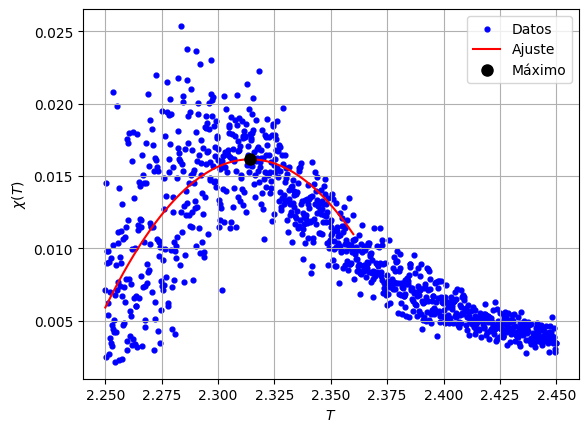

Parámetros de ajuste:
a: a=-2.4778599415177993 ± 0.17376873132129347
b: b=2.3143045404513978 ± 0.0011922823252293632
c: c=0.01615076027649149 ± 0.00022968610668476356
Máximo: T = 2.3143045404513978, chi = 0.01615076027649149


In [ ]:
T_nuevo_ajuste = np.linspace(2.25,2.36,500)
popt, pcov = curve_fit(cuadratica, T_nuevo_ajuste, suscep_60[:500], p0=(a_fit_30, b_fit_30, c_fit_30)) # Ajusto
perr       = np.sqrt(np.diag(pcov))
a_fit_60, b_fit_60, c_fit_60 = popt
a_err_60, b_err_60, c_err_60 = perr
ajuste_60  = cuadratica(T_nuevo_ajuste, a_fit_60, b_fit_60, c_fit_60)
T_60       = b_fit_60
chi_60     = cuadratica(T_60, a_fit_60, b_fit_60, c_fit_60)                                            # Valor de la cuadrática en T_max

plt.scatter(T, suscep_60, color='blue', s=12, label='Datos')
plt.plot(T_nuevo_ajuste, ajuste_60, 'r-', label='Ajuste')
plt.plot(T_60, chi_60, 'go', color='black', markersize=8, label='Máximo')
plt.xlabel('$T$', fontsize = 10)
plt.ylabel('$\chi(T)$', fontsize = 10)
plt.grid()
plt.legend()
plt.show()
print("Parámetros de ajuste:")
print(f"a: a={a_fit_60} ± {a_err_60}")
print(f"b: b={b_fit_60} ± {b_err_60}")
print(f"c: c={c_fit_60} ± {c_err_60}")
print(f"Máximo: T = {T_60}, chi = {chi_60}")

En esta ocasión, usamos N=20000 y definimos una nueva grilla T, para ajustar mejor con la cuadrática (usamos solo los datos hasta 2.36 para el ajuste).

In [ ]:
delta_T_60 = b_err_60
print("La temperatura máxima es:")
print(f"T = {T_60} ± {delta_T_60}")

La temperatura máxima es:
T = 2.3143045404513978 ± 0.0011922823252293632


### L = 120

In [ ]:
L    = 120                        # Lado de la red
N    = 10000                      # Número de pasos para llegar al equilibrio
S    = np.ones((L,L),dtype=int)
T    = np.linspace(2.25,2.35,500) # Creo una lista de valores de T bajos y cercanos al equilibrio
beta = 1/T                        # Creo el vector beta

In [ ]:
suscep_120 = [] # Creo una lista vacía para hallar los datos de susceptibilidad

for x in tqdm(beta):                         # Para los valores de beta, termalizamos, calculamos el valor medio de energía y magnetización.
  prob=np.array([np.exp(-4*x),np.exp(-8*x)])
  for n in range(N):
    S,dm,de=metropolis(S,prob)               # Termalizamos con metrópolis
  m=np.zeros(N)
  e=np.zeros(N)                              # Magnetización y energia por particula en funcion del paso
  m[0]=np.mean(S)
  e[0]=h(S)
  mmedia=[abs(m[0])]
  emedia=[e[0]]                              # Valores medios en funcion del numero de pasos para promediar
  for n in range(1,N):
    S,dm,de=metropolis(S,prob)
    m[n]=m[n-1]+dm
    e[n]=e[n-1]+de
    mmedia.append(np.mean(abs(m[0:n+1])))
    emedia.append(np.mean(e[0:n+1]))
  suscep_120.append(x*(np.std(abs(m))**2))
print(suscep_120)

100%|██████████| 500/500 [7:01:45<00:00, 50.61s/it]

[0.0028970709065602187, 0.0008345581746272147, 0.001778323234743646, 0.0007283269810024867, 0.0010048964100366174, 0.0038043550283310672, 0.000906999088687762, 0.0011013861134250519, 0.0017855030058027091, 0.001271265216163352, 0.0008279274575969795, 0.0011795611039600513, 0.0017400882616639207, 0.0012221002015271939, 0.0006464636331845274, 0.0021290245301368847, 0.001304223626813306, 0.0023355373420194487, 0.0036004647592127815, 0.0030551026733273545, 0.0012344059511139606, 0.0039105822474544685, 0.0012189929267265585, 0.0020829544361112852, 0.001303676690982851, 0.021689206846638845, 0.0006911677103813758, 0.004719420099500005, 0.0025941417865233745, 0.002839405787806318, 0.005560562861741776, 0.0019986047873581923, 0.0013157702689522623, 0.0026131763403639944, 0.000709911316992815, 0.005353924999899526, 0.0008273665858554371, 0.0146818234447828, 0.00244858007281953, 0.001833195681714409, 0.0014491029213493216, 0.0016134149215219736, 0.0011172764237945504, 0.00237466883826318, 0.0035

##### Vector suscep_120

In [ ]:
suscep_120 = [0.0028970709065602187, 0.0008345581746272147, 0.001778323234743646, 0.0007283269810024867, 0.0010048964100366174, 0.0038043550283310672, 0.000906999088687762, 0.0011013861134250519, 0.0017855030058027091, 0.001271265216163352, 0.0008279274575969795, 0.0011795611039600513, 0.0017400882616639207, 0.0012221002015271939, 0.0006464636331845274, 0.0021290245301368847, 0.001304223626813306, 0.0023355373420194487, 0.0036004647592127815, 0.0030551026733273545, 0.0012344059511139606, 0.0039105822474544685, 0.0012189929267265585, 0.0020829544361112852, 0.001303676690982851, 0.021689206846638845, 0.0006911677103813758, 0.004719420099500005, 0.0025941417865233745, 0.002839405787806318, 0.005560562861741776, 0.0019986047873581923, 0.0013157702689522623, 0.0026131763403639944, 0.000709911316992815, 0.005353924999899526, 0.0008273665858554371, 0.0146818234447828, 0.00244858007281953, 0.001833195681714409, 0.0014491029213493216, 0.0016134149215219736, 0.0011172764237945504, 0.00237466883826318, 0.0035680153314212983, 0.001554310049483475, 0.0013728932874172335, 0.0023038274509556297, 0.0006550435917344333, 0.0009268806616077236, 0.0032237213354870155, 0.001775150660818896, 0.0013807459291619087, 0.0006306532679749142, 0.0035928534542220194, 0.0029900727780320384, 0.0029034935547113234, 0.004852599758462701, 0.008420052475805266, 0.001736274741505312, 0.006831393058528566, 0.014080040400009486, 0.00429108841114655, 0.0020107927217585856, 0.00164761066913869, 0.0008610162655765888, 0.0009360830091501061, 0.0060198358138240995, 0.0011934588488663285, 0.0024926736150473463, 0.0014151589615363776, 0.0006031020476176561, 0.0030324500461052623, 0.004662863515089674, 0.0015227577025541837, 0.004638143662971632, 0.0011993254859330909, 0.0031532508341576807, 0.002450300536531361, 0.0014589342856555648, 0.0021970289771891167, 0.0014013629144750555, 0.0019223745672824815, 0.020437866969594643, 0.002122536118834834, 0.0043953163981635445, 0.01966750438525888, 0.0014867564656619052, 0.007770895513220616, 0.00837112118887288, 0.005429195954724707, 0.0017080435022964247, 0.006117783518827383, 0.002182040186032766, 0.0019492442613488316, 0.0016226539361352487, 0.003508047477076424, 0.001436624982831752, 0.0044285121762397415, 0.0013219872688962062, 0.002176662895339709, 0.013780165820449443, 0.005321051648675746, 0.004013727021213659, 0.005118322530594055, 0.005026428699972546, 0.011329357357255272, 0.0018360759605458245, 0.008136726616215575, 0.0015541926876816567, 0.006188988418460902, 0.0037173494507454444, 0.001817707571481737, 0.010470288268721177, 0.003006798101170855, 0.006699854685541147, 0.0032037316134330644, 0.006060916068469974, 0.0038030561537133016, 0.019572418045087202, 0.016432697219116704, 0.007737748042471917, 0.006007313148110761, 0.002352319749660329, 0.0017697572046167797, 0.0024902277749097503, 0.004494753709032337, 0.008508618948218118, 0.002197743209636388, 0.011807865732768402, 0.002726868537046035, 0.007858823050913571, 0.015369356467228758, 0.0014929649412390071, 0.005782888735937539, 0.011392384056950441, 0.002940411567542375, 0.016153036159454015, 0.002991532011138509, 0.007498397560531543, 0.005080401120325622, 0.005625142364366861, 0.007955707461653408, 0.0031116590082754443, 0.008428074401240913, 0.009669781936969, 0.004647789453730504, 0.0031929436818075602, 0.00573237442642942, 0.007220206994674669, 0.002611789706882134, 0.009875833491804037, 0.002452301687702278, 0.0031218353459459935, 0.00316590027444957, 0.001370801425968238, 0.001815423838083526, 0.012336514719111116, 0.019303110549145165, 0.00312073003814971, 0.007620861385230304, 0.015672711104292907, 0.002110193628855888, 0.005080422517012003, 0.010307111732141298, 0.009056737206266617, 0.015158059254891538, 0.0015095328278693788, 0.008609303926782014, 0.016983915432618478, 0.002130832011431841, 0.006209046560330799, 0.004905733798645581, 0.006012890362370996, 0.002800776527375962, 0.009601571208027225, 0.0059287327488738275, 0.004154561469995425, 0.013279771257872624, 0.0028013303535395907, 0.009879163148237132, 0.01140101574956112, 0.004457383398167807, 0.0016124784202606259, 0.009462424153197311, 0.009280214992190327, 0.009837974954240282, 0.0041961182744911585, 0.007473928604033749, 0.004192772122871346, 0.007300476482873222, 0.007061166721848108, 0.01357385725334789, 0.009983252311979114, 0.004053804548345727, 0.0076569045333888495, 0.00812773582586527, 0.0031303103200642627, 0.002405478545629462, 0.007672481692597658, 0.0041167916321048275, 0.0027208513751409693, 0.007077068196580964, 0.011253196661186364, 0.004166672472592432, 0.013484836311886775, 0.010023146111951271, 0.005444434244093058, 0.007117430513264579, 0.011163955156493708, 0.008873481212787868, 0.007976001473868264, 0.004964871735098814, 0.008516054310762626, 0.005672332734158943, 0.009573797586259203, 0.005758478413687546, 0.004815475528630616, 0.005383547466930739, 0.015412849783799122, 0.010840109555841028, 0.0064003994694325685, 0.009969792451408424, 0.014770677240675828, 0.005425477595281547, 0.015656604924660828, 0.007820173272771009, 0.009566766410706829, 0.012795642688273589, 0.008549227039362683, 0.00823934961773778, 0.008749320486411265, 0.004335926288826539, 0.0025498932158947657, 0.009030507537883413, 0.012322718323586482, 0.004460759178605109, 0.005830935616018788, 0.007646953997690621, 0.005677151264265276, 0.008218141724977021, 0.004602210219776858, 0.009015467581634561, 0.004898411682683748, 0.005640213739738301, 0.01102981698546816, 0.009309266318884244, 0.006382803540518911, 0.0032195140412017206, 0.009890606957266344, 0.007018252489966313, 0.008868969103172912, 0.008800450870660925, 0.006544897875206947, 0.004507991965570324, 0.007811294881087357, 0.0157897482077832, 0.011769243407230163, 0.0172863655381115, 0.010466297788587847, 0.006797836697861599, 0.005398835909202981, 0.004675467533426035, 0.010429855834161521, 0.002496049336788437, 0.01249556715963381, 0.011727838244674353, 0.007217740436254218, 0.0029890995252975553, 0.014428575438550716, 0.009126681440051023, 0.010155680789487512, 0.010776401351073014, 0.009583146037105831, 0.009557589564453543, 0.013227742596828228, 0.008036497040732631, 0.002398905934673908, 0.01660317937706418, 0.0048727134097913075, 0.01076381966434754, 0.017105219409958468, 0.013199522545627044, 0.006548094293539966, 0.005872841809436938, 0.0034841001287785524, 0.0041362023332215045, 0.004404270772238245, 0.015649578921006463, 0.009766318042526693, 0.01228617140630164, 0.004915082358179493, 0.009401218263425866, 0.0096686172920976, 0.0025512995098618922, 0.009554004872268098, 0.006941769212818409, 0.009096128997636793, 0.006288141912328405, 0.005835884970894697, 0.005879915970562128, 0.003991800672983237, 0.00891920541226257, 0.01068767894915798, 0.009509455223620896, 0.006835403053395281, 0.004330583950568489, 0.0047366225720397405, 0.009161520871899559, 0.00937755904514939, 0.007554800253325313, 0.01241084241374261, 0.0042819060368583925, 0.008279870110217684, 0.006294316236003359, 0.009876139598110237, 0.00885804993499881, 0.006888885741050902, 0.005429312145377933, 0.007622281573533667, 0.004956534805164513, 0.005845700497718748, 0.004220967910334307, 0.0038082214077091964, 0.010222680683414566, 0.008281710518089262, 0.006409519415003758, 0.009368394051276438, 0.010743416344978263, 0.004936716279191585, 0.006909849913254138, 0.007937811927878529, 0.006006687499276902, 0.004979590812937591, 0.00678186820740272, 0.006008273970613198, 0.007397789213335316, 0.006440250491525518, 0.003769647082612613, 0.011092956388306183, 0.004654738084758227, 0.0036452382397657414, 0.005909178235338276, 0.00767885155213346, 0.009550548048209373, 0.007654248308892676, 0.007147522734053972, 0.008475740290589933, 0.0032448484622166827, 0.007591645425236452, 0.00139689696706593, 0.0029418102386388327, 0.00719466836178911, 0.0036913997795824435, 0.002786618710071642, 0.006054346582347543, 0.009087742151951995, 0.011880188217209714, 0.0032109229417700115, 0.006114155574886044, 0.003195839364969221, 0.010148908293177767, 0.004613917536144401, 0.00859362938825157, 0.008864761496115394, 0.008589095856737186, 0.003576498530407331, 0.00732213748865112, 0.0035668726378083894, 0.0031002473173321918, 0.0036911886798831326, 0.006228410506903728, 0.004611117144631634, 0.004167221533602792, 0.005201659490127421, 0.00274313551477051, 0.010264824896318567, 0.004298643106631859, 0.0031642480225356523, 0.004733545772344189, 0.006986571235158967, 0.003370007076787301, 0.004105519988765589, 0.004116341603557354, 0.005054462556698506, 0.004263174037836446, 0.0030734679111086762, 0.0023309076400257617, 0.0045779549123965285, 0.005775085687656187, 0.003776100934504862, 0.005929782557634493, 0.005279522262102979, 0.006341087147347897, 0.0043766175006640816, 0.006001431969454625, 0.0028810610909657604, 0.006380341947509266, 0.005313342443431538, 0.004841691226276782, 0.0029494766932431117, 0.0028826853185870156, 0.007131042550519338, 0.002352416370116473, 0.0029008870029875993, 0.003386283321495576, 0.0077610098681082495, 0.005115979511358023, 0.0027656426525598174, 0.006680673051757772, 0.0045188919341278624, 0.006598224184656108, 0.00521730004792408, 0.0019322962474221256, 0.0024018224685487494, 0.002514833046108056, 0.002431853217708839, 0.004268355416242877, 0.0034333560239163587, 0.003169503917202094, 0.004297975665657051, 0.00476947446166009, 0.0051107153151482565, 0.006159732525359017, 0.004714919953582896, 0.0029358746242743906, 0.004315530596713872, 0.003394069230632265, 0.004117287485696836, 0.003168988209262651, 0.005592513049002923, 0.00410099035821815, 0.005645292660916333, 0.003913542799938048, 0.004663843196327624, 0.0028414762428182814, 0.0025373051205729207, 0.0036701621430607063, 0.004719754663431323, 0.0045418653410024675, 0.006257840185352577, 0.0021218118905891046, 0.004824462608071531, 0.003979897620153368, 0.0028079182313990006, 0.0032659140568088102, 0.002909235397667827, 0.0029323873072222843, 0.00315533849381567, 0.0027851236302444057, 0.007085408519170564, 0.002318545928181636, 0.002210108200016878, 0.005564251499508647, 0.002067840641065926, 0.002742177357895201, 0.0049953574640790805, 0.0082747336521912, 0.0041271774837339775, 0.00462958997665579, 0.0028576955789985296, 0.0027946998671741895, 0.0036446390084307603, 0.003821033773198732, 0.0025804667762328614, 0.0027823216203072894, 0.003739902523842393, 0.006381513337099107, 0.0017714667513597567, 0.002344123394098705, 0.0026389102951441435, 0.005735185427103183, 0.005507986242289269, 0.0024420731421975752, 0.0027852707172942785, 0.004008443630355439, 0.0026660043646340443, 0.003535330005909301, 0.0035602669145735483, 0.006373002670682177, 0.0018292373398141406, 0.003400616160552606, 0.0035447912532218877, 0.003312908246747238, 0.0032841015368125673, 0.002515035931684016, 0.004230486953910505, 0.0020904922168825716, 0.0019049017325675887, 0.0057103950159193805, 0.003830525210638564, 0.005428681478313946, 0.002373405393537898, 0.002918006728705458, 0.001927775528374238, 0.004251311920345268, 0.0032565803013899853, 0.002296683779049943, 0.0030034112608336968, 0.002914526313601263]


##### Ajuste

<ipython-input-47-4d403e42852c>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(T_120, chi_120, 'go', color='black', markersize=8, label='Máximo')


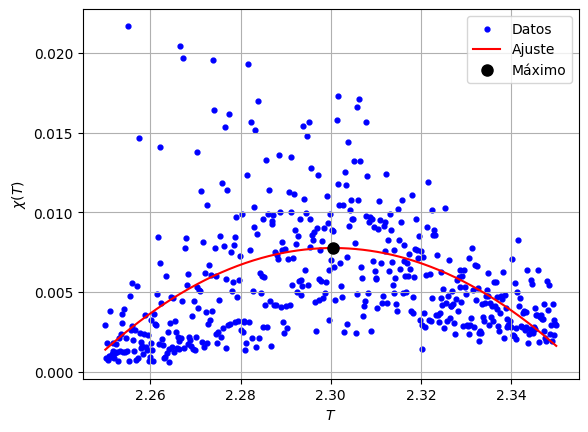

Parámetros de ajuste:
a: a=-2.504119932970752 ± 0.19950809196071123
b: b=2.300473801474962 ± 0.0010313043864199184
c: c=0.007752364699668997 ± 0.00022393021667625358
Máximo: T = 2.300473801474962, chi = 0.007752364699668997


In [ ]:
popt, pcov = curve_fit(cuadratica, T, suscep_120, p0=(a_fit_60, b_fit_60, c_fit_60)) # Ajusto
perr       = np.sqrt(np.diag(pcov))
a_fit_120, b_fit_120, c_fit_120 = popt
a_err_120, b_err_120, c_err_120 = perr
ajuste_120 = cuadratica(T, a_fit_120, b_fit_120, c_fit_120)
T_120      = b_fit_120
chi_120    = cuadratica(T_120, a_fit_120, b_fit_120, c_fit_120)                      # Valor de la cuadrática en T_max

plt.scatter(T, suscep_120, color='blue', s=12, label='Datos')
plt.plot(T, ajuste_120, 'r-', label='Ajuste')
plt.plot(T_120, chi_120, 'go', color='black', markersize=8, label='Máximo')
plt.xlabel('$T$', fontsize = 10)
plt.ylabel('$\chi(T)$', fontsize = 10)
plt.grid()
plt.legend()
plt.show()
print("Parámetros de ajuste:")
print(f"a: a={a_fit_120} ± {a_err_120}")
print(f"b: b={b_fit_120} ± {b_err_120}")
print(f"c: c={c_fit_120} ± {c_err_120}")
print(f"Máximo: T = {T_120}, chi = {chi_120}")

In [ ]:
delta_T_120 = b_err_120
print("La temperatura máxima es:")
print(f"T = {T_120} ± {delta_T_120}")

La temperatura máxima es:
T = 2.300473801474962 ± 0.0010313043864199184


### Ajuste Lineal

Parámetros de ajuste:
Pendiente (a): 1.863955972251005 ± 0.051390417638151366
Ordenada (Tc): 2.284682304462324 ± 0.0014124479187806096


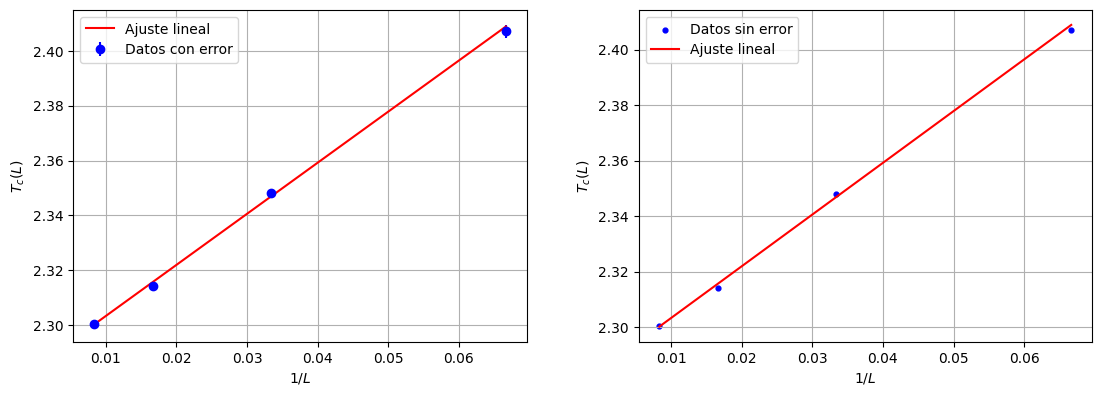

In [ ]:
T_c          = [T_15,T_30,T_60,T_120]
T_c_err      = [delta_T_15,delta_T_30,delta_T_60,delta_T_120]
L_inv        = [1/15,1/30,1/60,1/120]
popt, pcov   = curve_fit(lineal, L_inv, T_c, sigma=T_c_err)#, absolute_sigma=True)
perr         = np.sqrt(np.diag(pcov))
a_fit, b_fit = popt
a_err, b_err = perr

x_fit = np.linspace(1/120, 1/15, 100) # Genero una malla para ajustar en x
y_fit = lineal(x_fit, a_fit, b_fit)

fig, ax = plt.subplots(1, 2, figsize= (12,5))
plt.tight_layout(pad=5.0)
ax[0].errorbar(L_inv, T_c, yerr=T_c_err, fmt='o', color='blue', label='Datos con error')
ax[0].plot(x_fit, y_fit, 'r-', label='Ajuste lineal')
ax[0].set_xlabel('$1/L$', fontsize = 10)
ax[0].set_ylabel('$T_c(L)$', fontsize = 10)
ax[0].grid(True)
ax[0].legend()
ax[1].scatter(L_inv, T_c, color='blue', s=12, label='Datos sin error')
ax[1].plot(x_fit, y_fit, 'r-', label='Ajuste lineal')
ax[1].set_xlabel('$1/L$', fontsize = 10)
ax[1].set_ylabel('$T_c(L)$', fontsize = 10)
ax[1].grid(True)
ax[1].legend()
print("Parámetros de ajuste:")
print(f"Pendiente (a): {a_fit} ± {a_err}")
print(f"Ordenada (Tc): {b_fit} ± {b_err}")

**Explicación:** Finalmente, acá realizamos simplemente un ajuste lineal de las temperaturas (en el eje vertical) con sus respectivas incertezas por propagación de errores, con respecto a la inversa de la red en el eje horizontal (1/L).

Debido a que los errores son muy grandes, ploteamos también los datos sin barras de error. Barras de error tan grandes son razonables debido a que los ajustes fueron muy malos, la dispersión en los datos era muy grande y es muy difícil (sino imposible) decir que una función cuadrática ajustaba los datos obtenidos.

#———————————————————————————————————————————————————————————————————————————————————————————————

#———————————————————————————————————————————————————————————————————————————————————————————————